# Transactions Fraud Detection

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Timotej Zatko](https://github.com/timzatko)

## Nature Inspired Algorithms - feature selection on sample of the dataset

Since the feature selection took too long on the full dataset (which was also undersampled), for research purposes we will do a featue selection only on the fraction of it, to examine the differences between the NIA algorithms and its configurations.

In this notebook we will compare the following algorithms from __Xin-She Yang__: Firefly Algorithm, Cuckoo Search Algorithm, Bat Algorithm, Flower Pollination Algorithm + Grey Wolf Algorithm.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import seaborn as sns

import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams.update({'font.size': 15})

%config InlineBackend.figure_format='retina'

## Load the data

In [4]:
from src.dataset import load_processed_data

x_train, y_train, x_test, y_test = load_processed_data()

Number of records:
  x_train - 472432
  y_train - 472432
  x_test - 118108
  y_test - 118108


We will firstly undersample the predicted classes to shrink the dataset size.

In [5]:
from src.data_balancing import random_undersample

x_train, y_train = random_undersample(x_train, y_train)

len(x_train), len(y_train)

(32842, 32842)

Then we shrink the dataset egain to 5% of the size, so the training won't take that much time. 

In [6]:
from src.dataset import shrink_data

frac = 0.05

n_train = int(len(x_train) * frac)

x_train = shrink_data(x_train, n_train, random_state=420)
y_train = shrink_data(y_train, n_train, random_state=420)

len(x_train), len(y_train)

(1642, 1642)

Also shrink the test dataset size, since the train was random undersampled and then shrank, we need to recalculate the test size.

In [7]:
n_test = int(0.2 / 0.8 * len(x_train))

x_test = shrink_data(x_test, n_test, random_state=420)
y_test = shrink_data(y_test, n_test, random_state=420)

len(x_test), len(y_test)

(410, 410)

## Experiments

As in the previous experiments, we will use decision tree as our classifier.

We won't set any hyper-parameters and leave it as it is.

In [8]:
from sklearn.tree import DecisionTreeClassifier


def model_fn():
    return DecisionTreeClassifier(random_state=42)

We will split the train data to train and val for feature selection.

- we will use the same metric (roc auc score) as the one used in the competetion
- we won't do a cross-validation yet (because of the training time)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

columns_count = len(x_train.columns)

_x_train, _x_val, _y_train, _y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

We will setup the classification benchmark which is required by NiaPy library.

In [10]:
from src.classification_benchmark import ClassificationBenchmark

benchmark = ClassificationBenchmark(
    model_fn,
    roc_auc_score,
    _x_train,
    _y_train,
    _x_val,
    _y_val
)

In [11]:
import numpy as np

from NiaPy.task import OptimizationType

from src.tasks import StoppingTaskWithLogging
from src.analysis import show_optimization_run_plot


def run_optimization_once(benchmark, algorithm, nGEN):
    """
    Does feature selection using specified algortithm.
    Returns the optimal columns, model score and the task which was optimized.
    
    :param benchmark: NiaPy.Benchmark to optimize.
    :param algorithm: algorithm object to use for optimization task.
    :param nGEN: number of generations.
    """
    
    # when using OptimizationType.MAXIMIZATION, the library will fail
    # we use OptimizationType.MINIMIZATION instead and invert the score
    task = StoppingTaskWithLogging(
        D=benchmark.get_length(),
        nGEN=nGEN,
        optType=OptimizationType.MINIMIZATION,
        benchmark=benchmark
    )

    solution_vec, score = algorithm.run(task=task)    

    if algorithm.exception is not None:
        raise algorithm.exception
    
    # invert the score
    score = 1 - score
    columns = benchmark.select_columns(solution_vec)
    
    return score, columns, task


def run_optimization(benchmark, algorithm, nGEN, number_of_runs=5):
    """
    Optimize task with provided algorithm.
    
    :param benchmark: NiaPy.Benchmark to optimize.
    :param algorithm: algorithm object to use for optimization task.
    :param nGEN: number of generations.
    :param number_of_runs: number of algorithm runs (defaults to 5).
    """
    best_columns = None
    best_score = 0
    
    scores = []
    
    for i in range(number_of_runs):
        print('--------------')
        print(f'Run {i + 1}')
        print('--------------')
        
        score, columns, task = run_optimization_once(benchmark, algorithm, nGEN)
        
        show_optimization_run_plot(task, f'{type(algorithm).__name__} run #{i}')
        
        print(f'Score: {score}')
        print(f'Number of features selected: {len(columns)}\n')
        print('\n')
        
        if score > best_score:
            best_score = score
            best_columns = columns
            
        scores.append(score)
        
    mean_score = np.mean(scores)

    print(f'\nMean score of {number_of_runs} runs: {mean_score}\n\n')
    
    print(f'\nBest score of {number_of_runs} runs: {best_score}')
    print(f'Number of features selected: {len(best_columns)}')
    
    return mean_score

__Experiments strategy__

- we will examine the following algorithms: Firefly Algorithm, Cuckoo Search Algorithm, Bat Algorithm, Flower Pollination Algorithm, Grey Wolf Algorithm
- we will train several population sizes (10, 20, 50) each of them up to 50 generations
- we will do 5 runs for each population size and we will report the mean best score from each run

In [12]:
population_sizes = [10, 25, 50]
number_of_generations = 50
number_of_runs = 3

In [13]:
def run_experiment(algorithm):
    best_score = 0
    best_population_size = None

    for population_size in population_sizes:    
        algorithm.setParameters(NP=population_size)

        print('========================================================')
        print(type(algorithm).__name__)
        print(f'population_size={population_size}')
        print(f'number_of_generations={number_of_generations}')
        print('========================================================')

        score = run_optimization(benchmark, algorithm, number_of_generations, number_of_runs=number_of_runs)

        if score > best_score:
            best_score = score
            best_population_size = population_size

        print('\n\n')
        
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    
    print(f'The best score is {best_score} with population_size={best_population_size}\n')

### Firefly Algorithm (FA)

[Firefly Algorithm](https://github.com/NiaOrg/NiaPy/blob/master/NiaPy/algorithms/basic/fa.py) default parameters:
- alpha = 1
- betamin = 1
- gamma = 2

FireflyAlgorithm
population_size=10
number_of_generations=50
--------------
Run 1
--------------


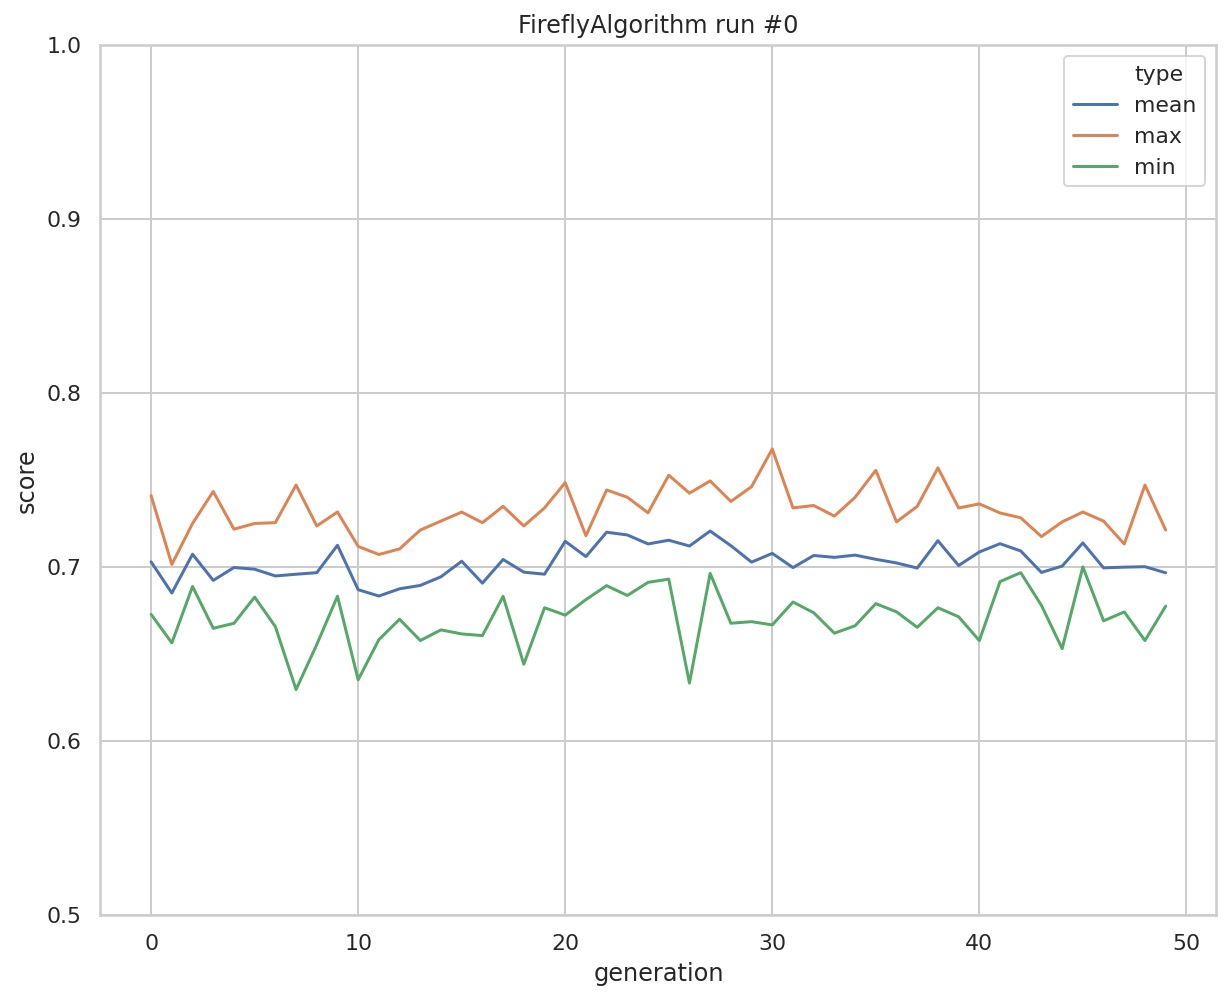

Score: 0.7676553672316384
Number of features selected: 122



--------------
Run 2
--------------


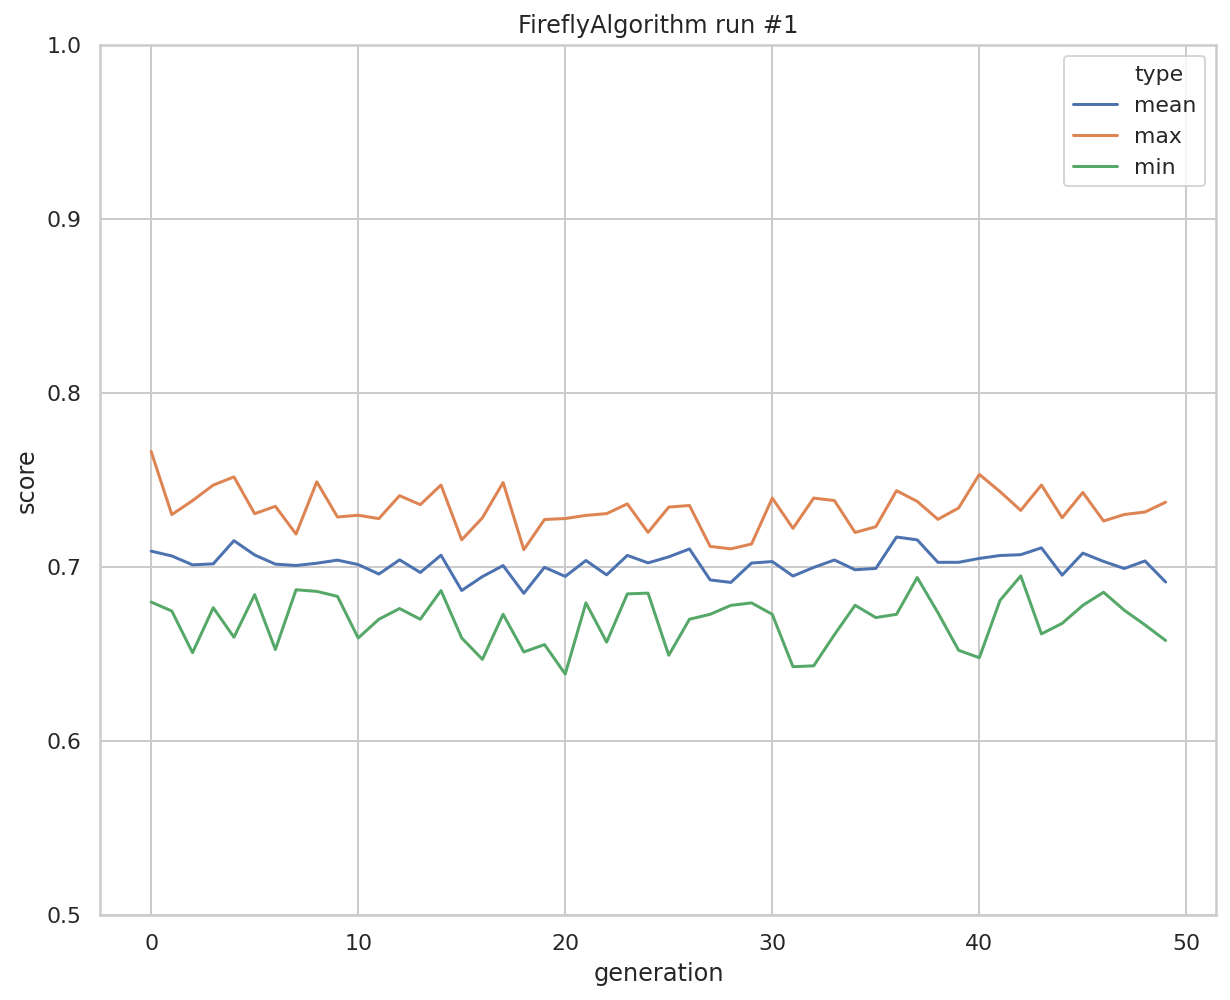

Score: 0.7662243532560213
Number of features selected: 118



--------------
Run 3
--------------


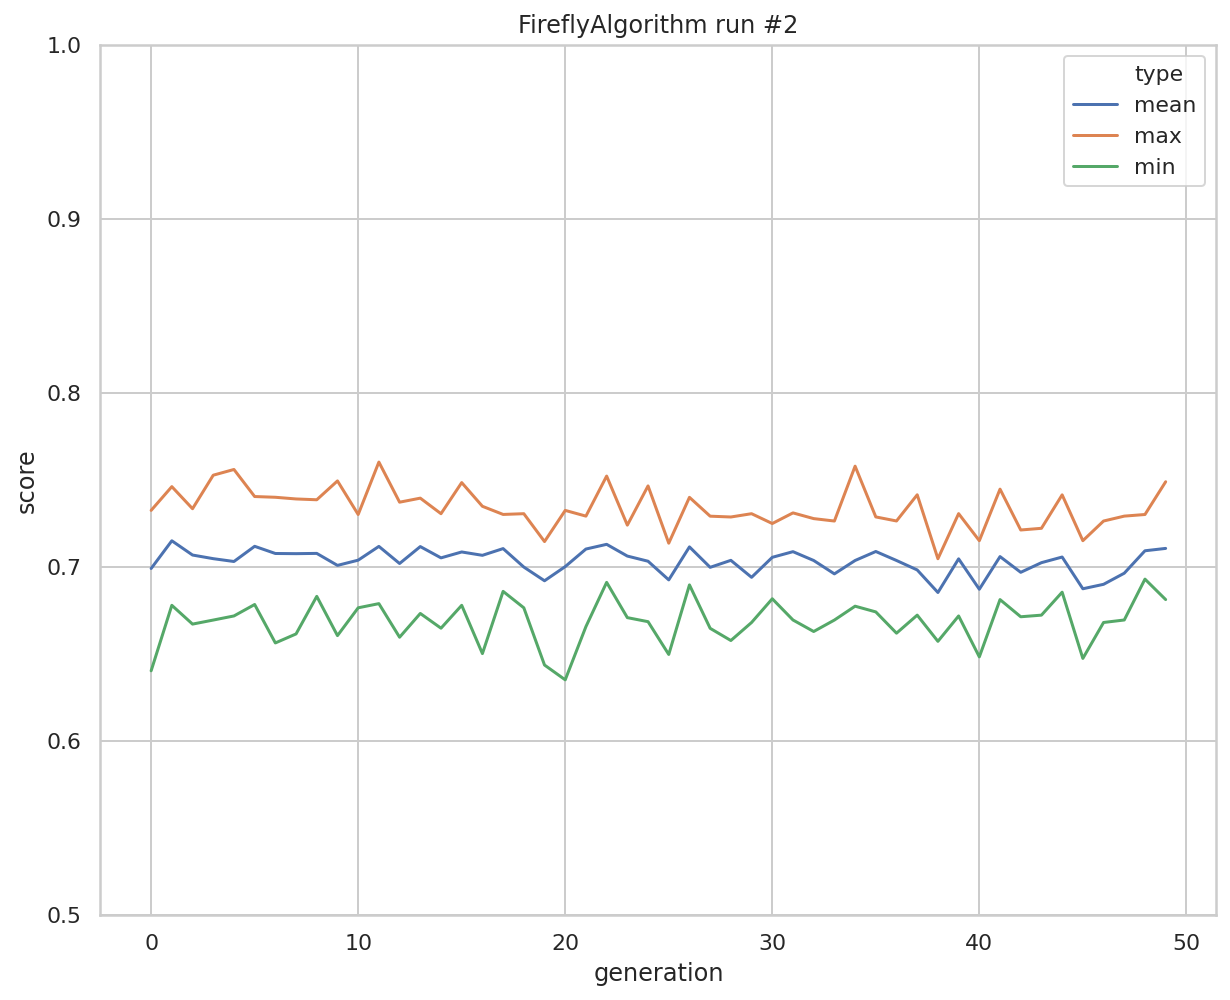

Score: 0.7601471900089206
Number of features selected: 129




Mean score of 3 runs: 0.7646756368321935



Best score of 3 runs: 0.7676553672316384
Number of features selected: 122



FireflyAlgorithm
population_size=25
number_of_generations=50
--------------
Run 1
--------------


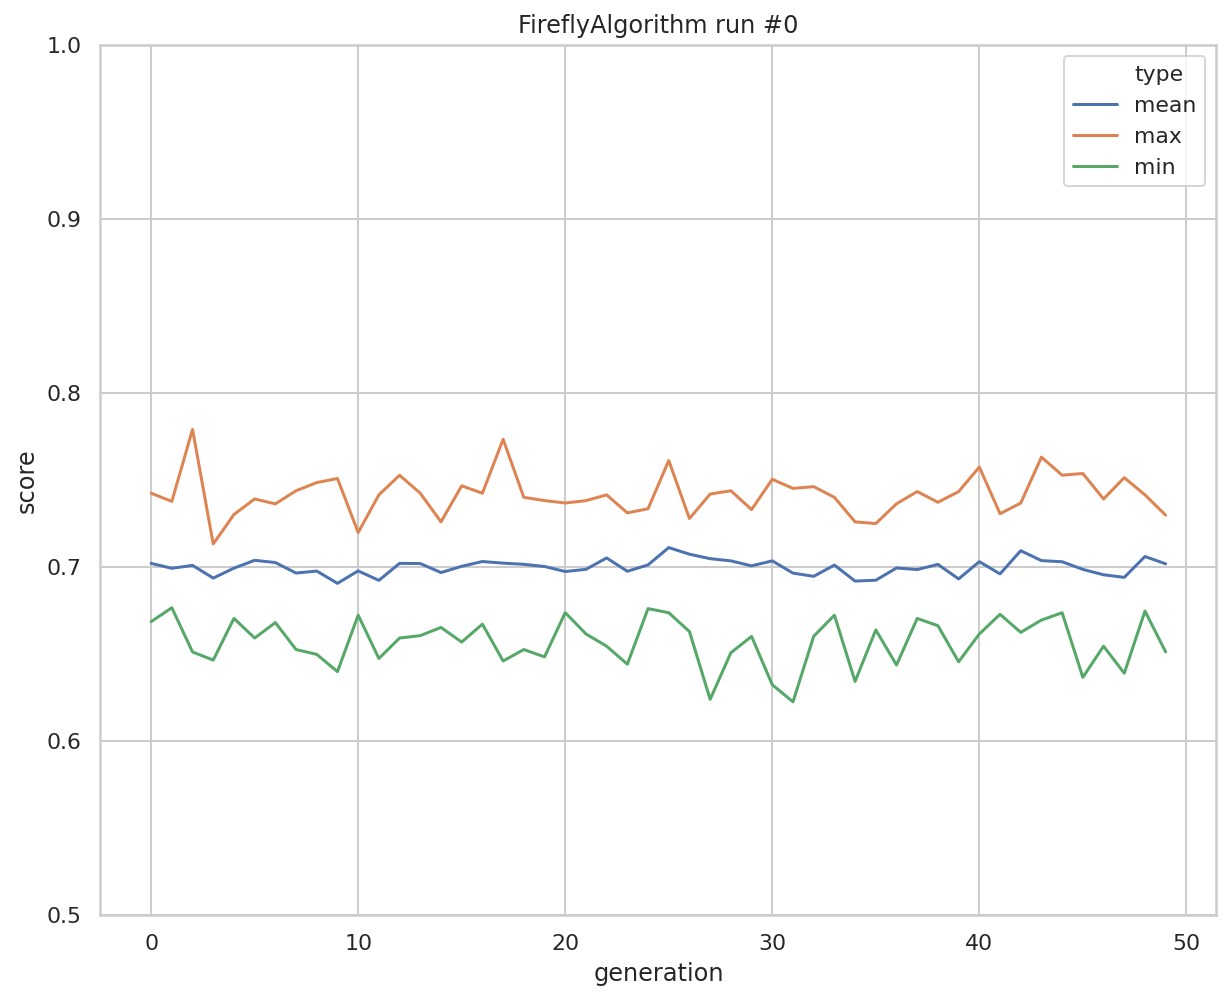

Score: 0.7789176330657152
Number of features selected: 118



--------------
Run 2
--------------


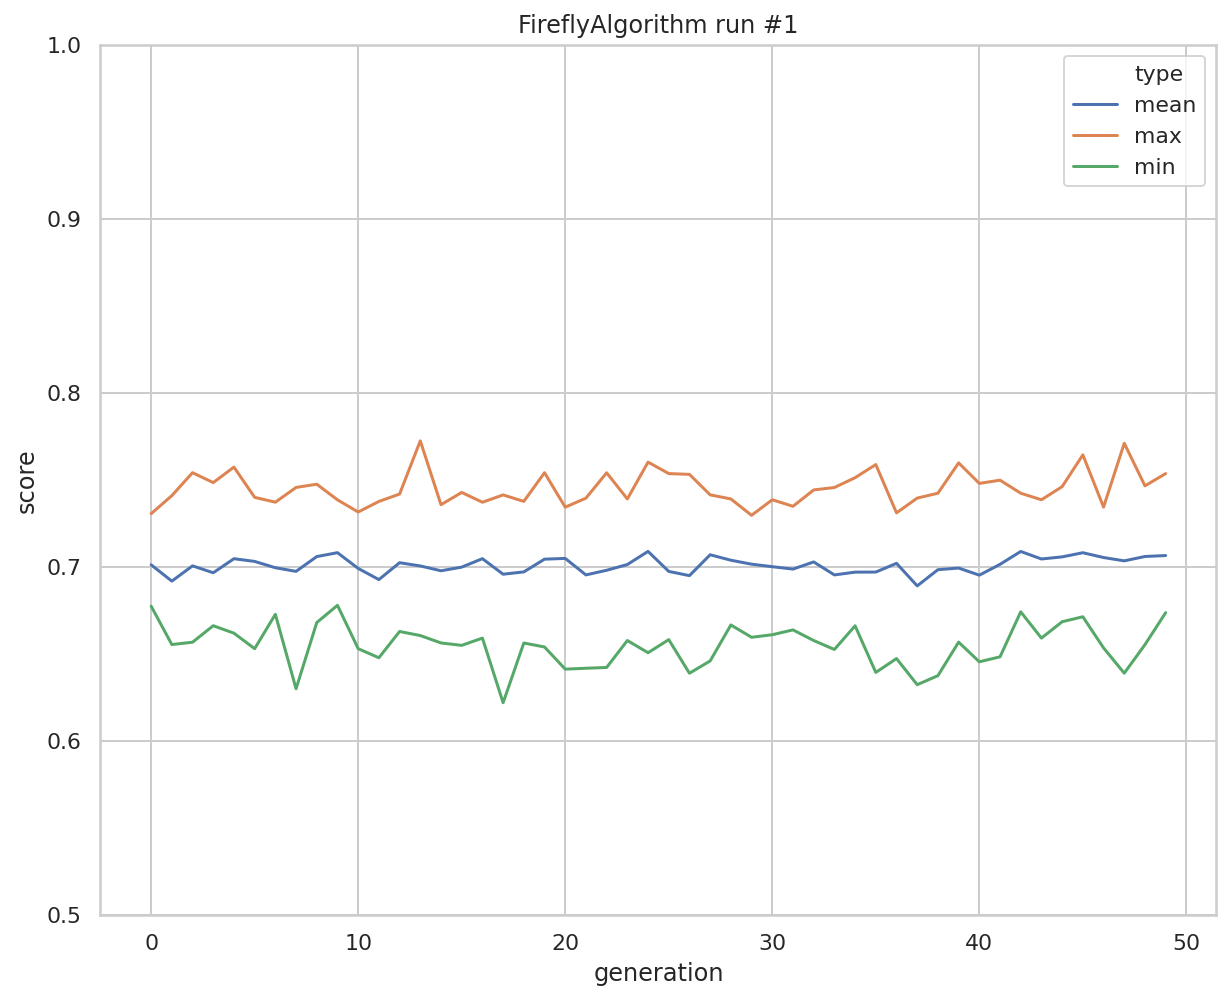

Score: 0.772338685697294
Number of features selected: 120



--------------
Run 3
--------------


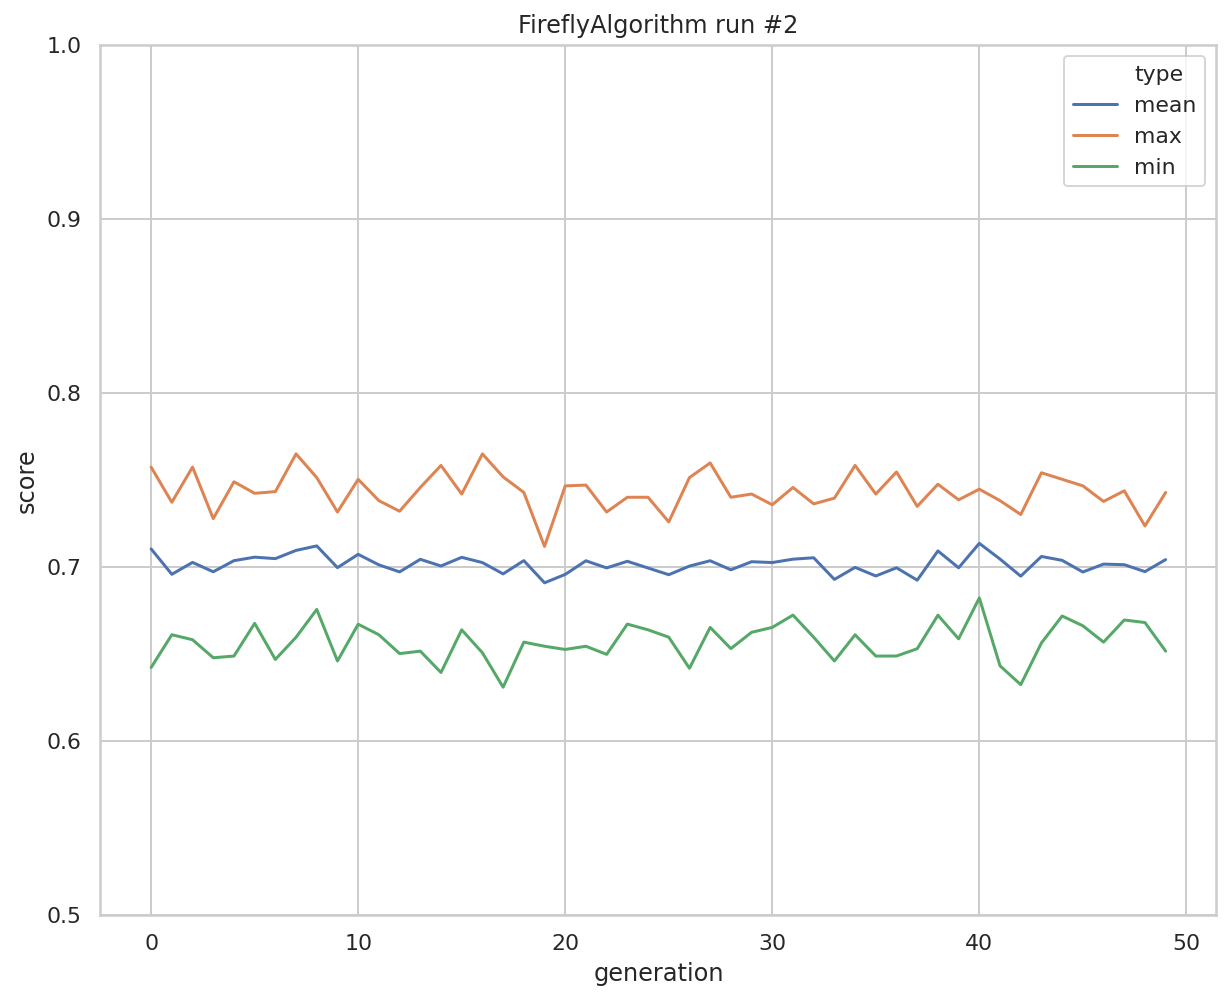

Score: 0.7648676776687481
Number of features selected: 128




Mean score of 3 runs: 0.7720413321439191



Best score of 3 runs: 0.7789176330657152
Number of features selected: 118



FireflyAlgorithm
population_size=50
number_of_generations=50
--------------
Run 1
--------------


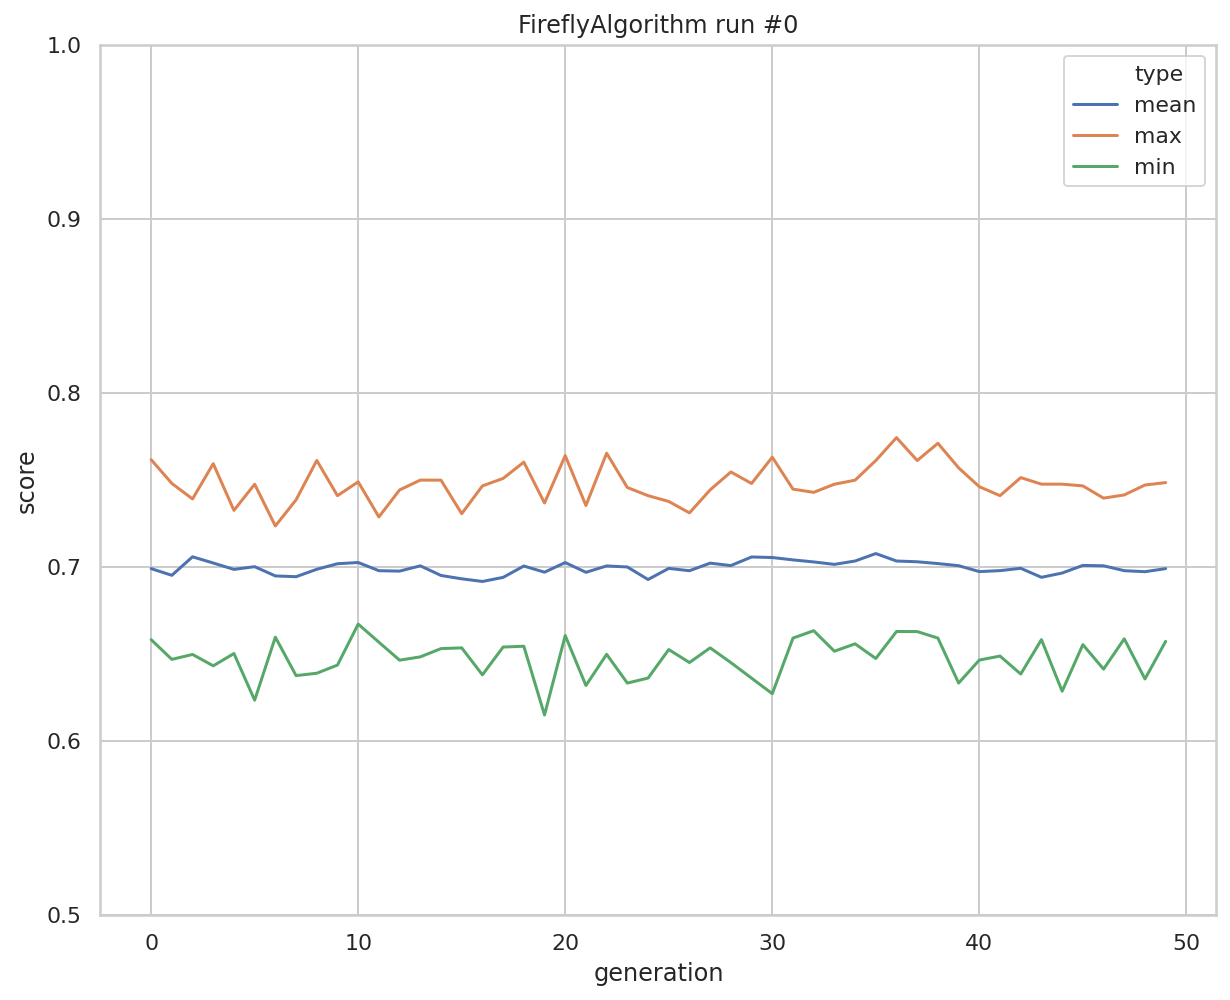

Score: 0.7741971454058877
Number of features selected: 127



--------------
Run 2
--------------


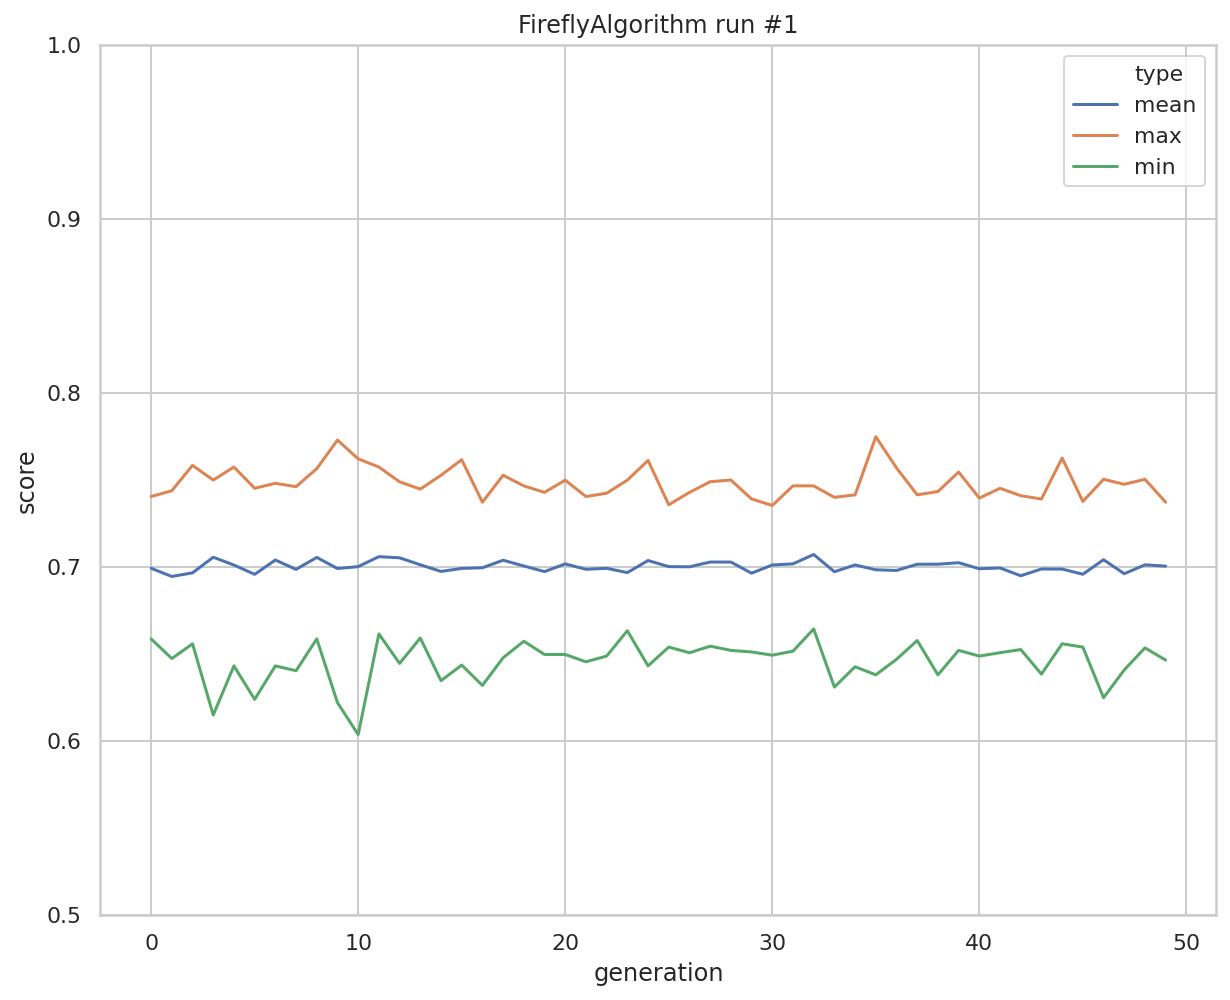

Score: 0.7746989295272079
Number of features selected: 122



--------------
Run 3
--------------


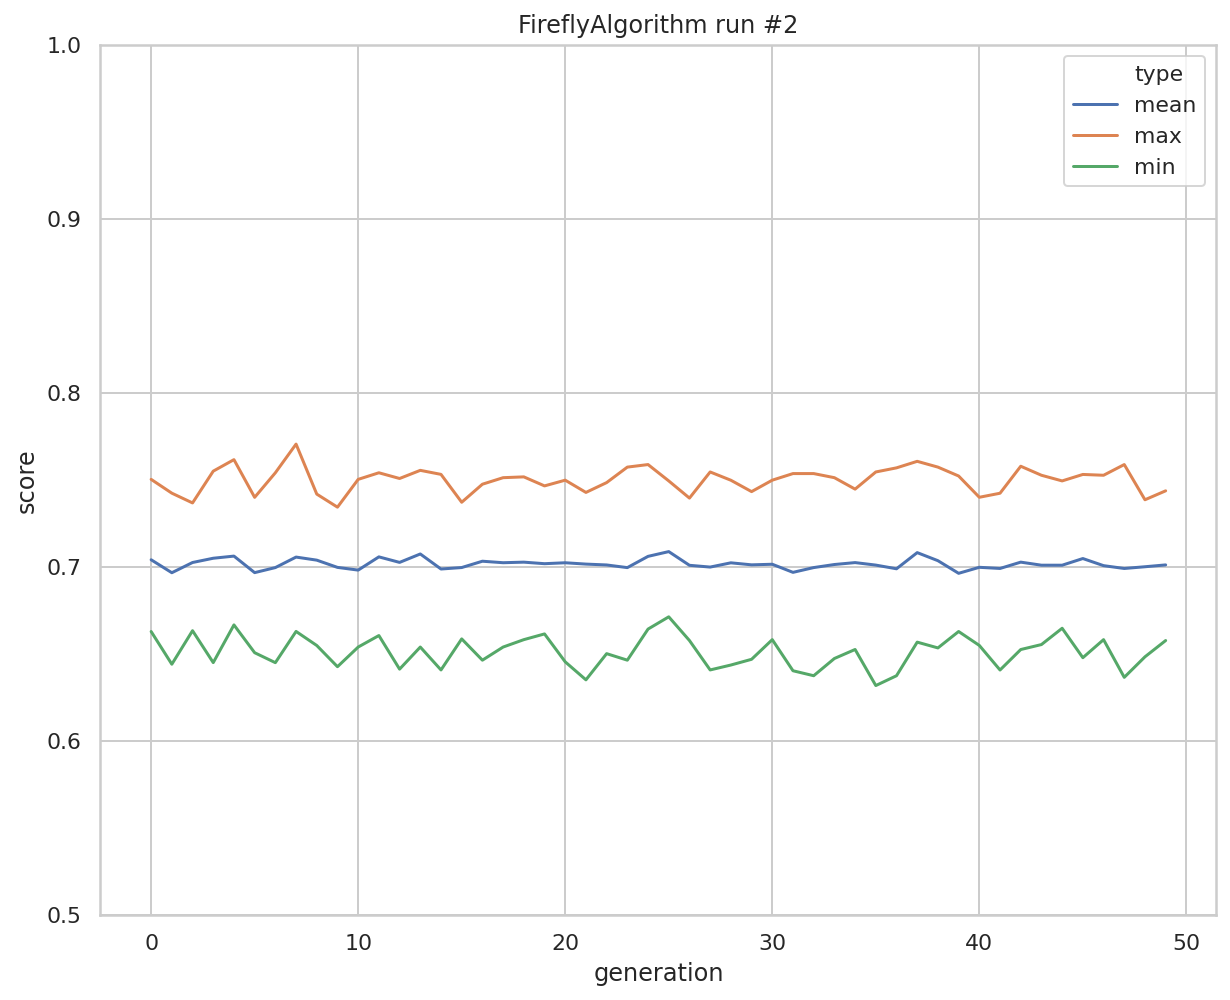

Score: 0.7704802259887006
Number of features selected: 119




Mean score of 3 runs: 0.7731254336405987



Best score of 3 runs: 0.7746989295272079
Number of features selected: 122



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The best score is 0.7731254336405987 with population_size=50

CPU times: user 7min 40s, sys: 2.83 s, total: 7min 43s
Wall time: 7min 44s


In [14]:
%%time

from NiaPy.algorithms.basic import FireflyAlgorithm

run_experiment(FireflyAlgorithm())

### Cuckoo Search Algorithm

[Cuckoo Search Algorithm](https://github.com/NiaOrg/NiaPy/blob/master/NiaPy/algorithms/basic/cs.py) default parameters:
- pa = 0.2
- alpha = 0.5

CuckooSearch
population_size=10
number_of_generations=50
--------------
Run 1
--------------


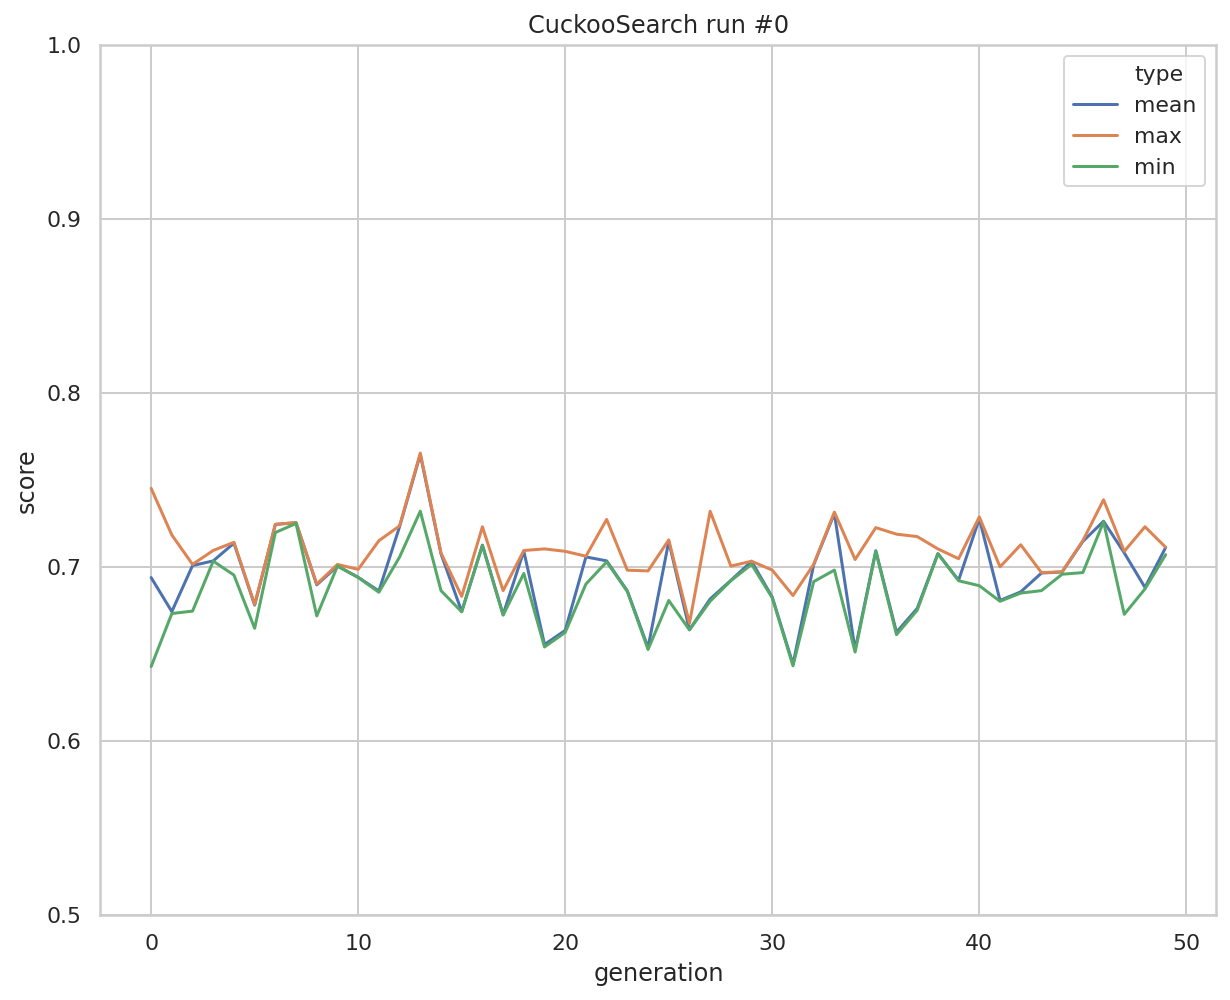

Score: 0.7653322925958966
Number of features selected: 124



--------------
Run 2
--------------


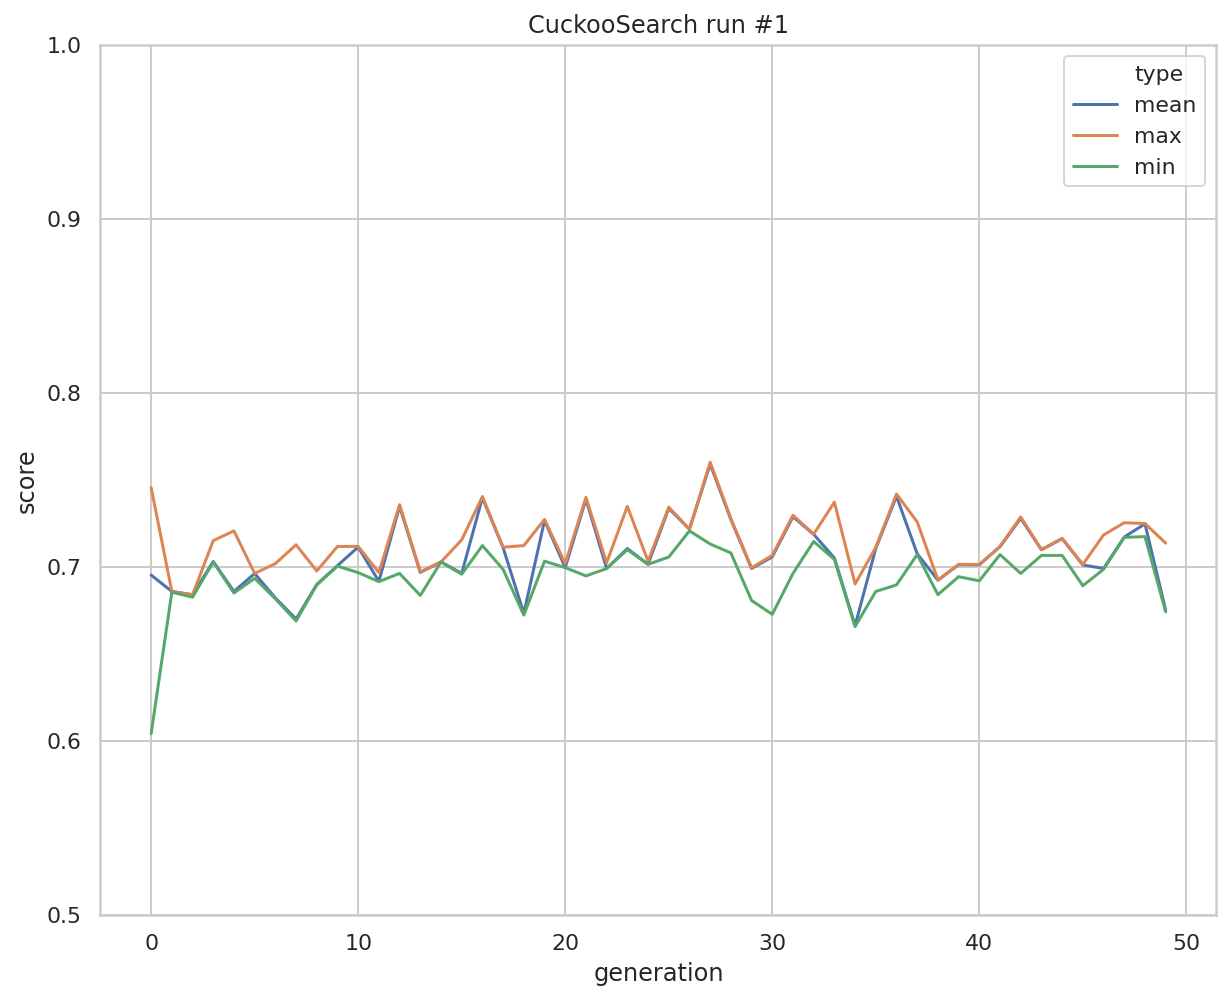

Score: 0.7601100208147488
Number of features selected: 128



--------------
Run 3
--------------


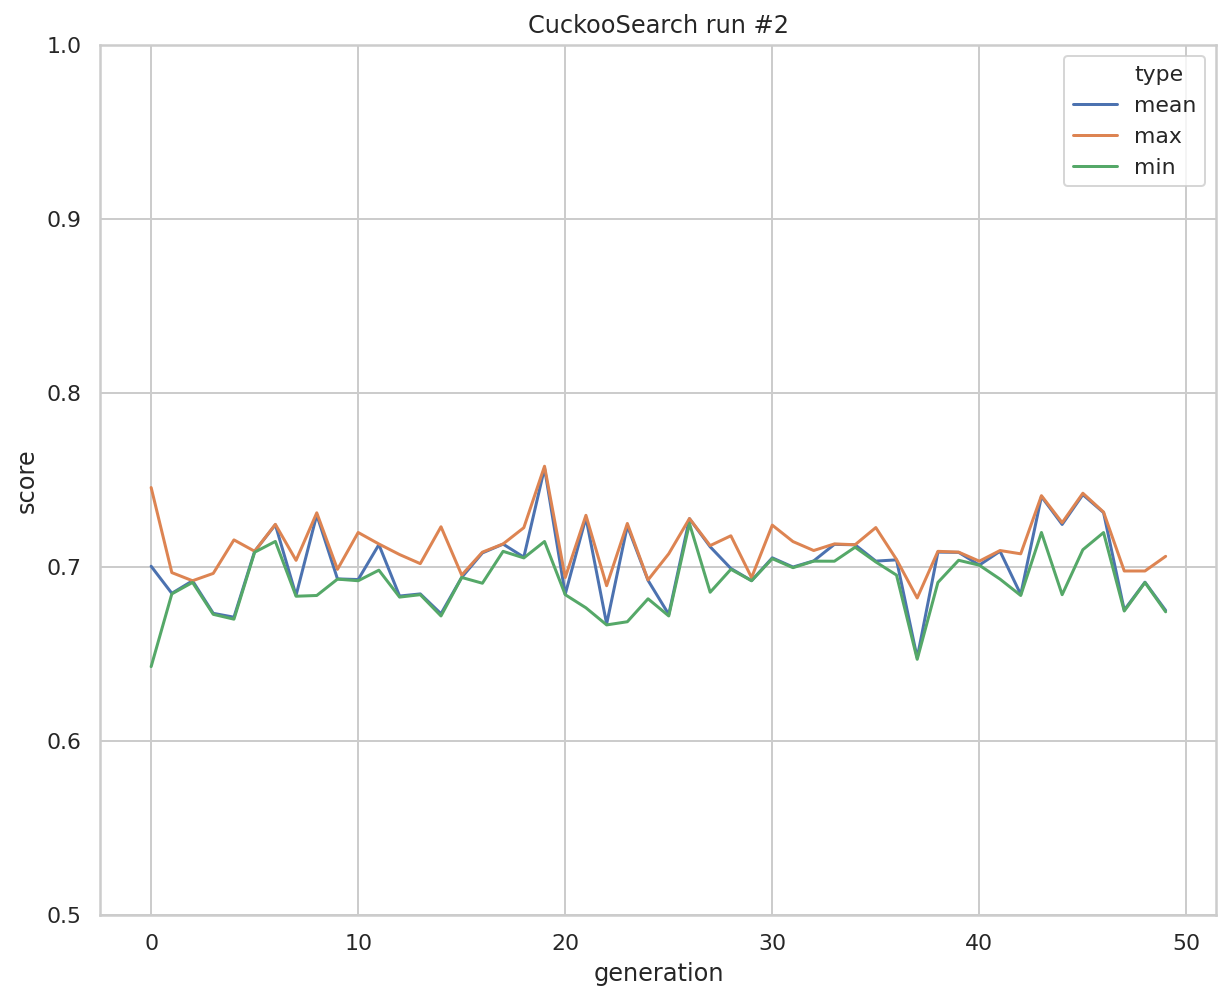

Score: 0.757749776984835
Number of features selected: 131




Mean score of 3 runs: 0.7610640301318269



Best score of 3 runs: 0.7653322925958966
Number of features selected: 124



CuckooSearch
population_size=25
number_of_generations=50
--------------
Run 1
--------------


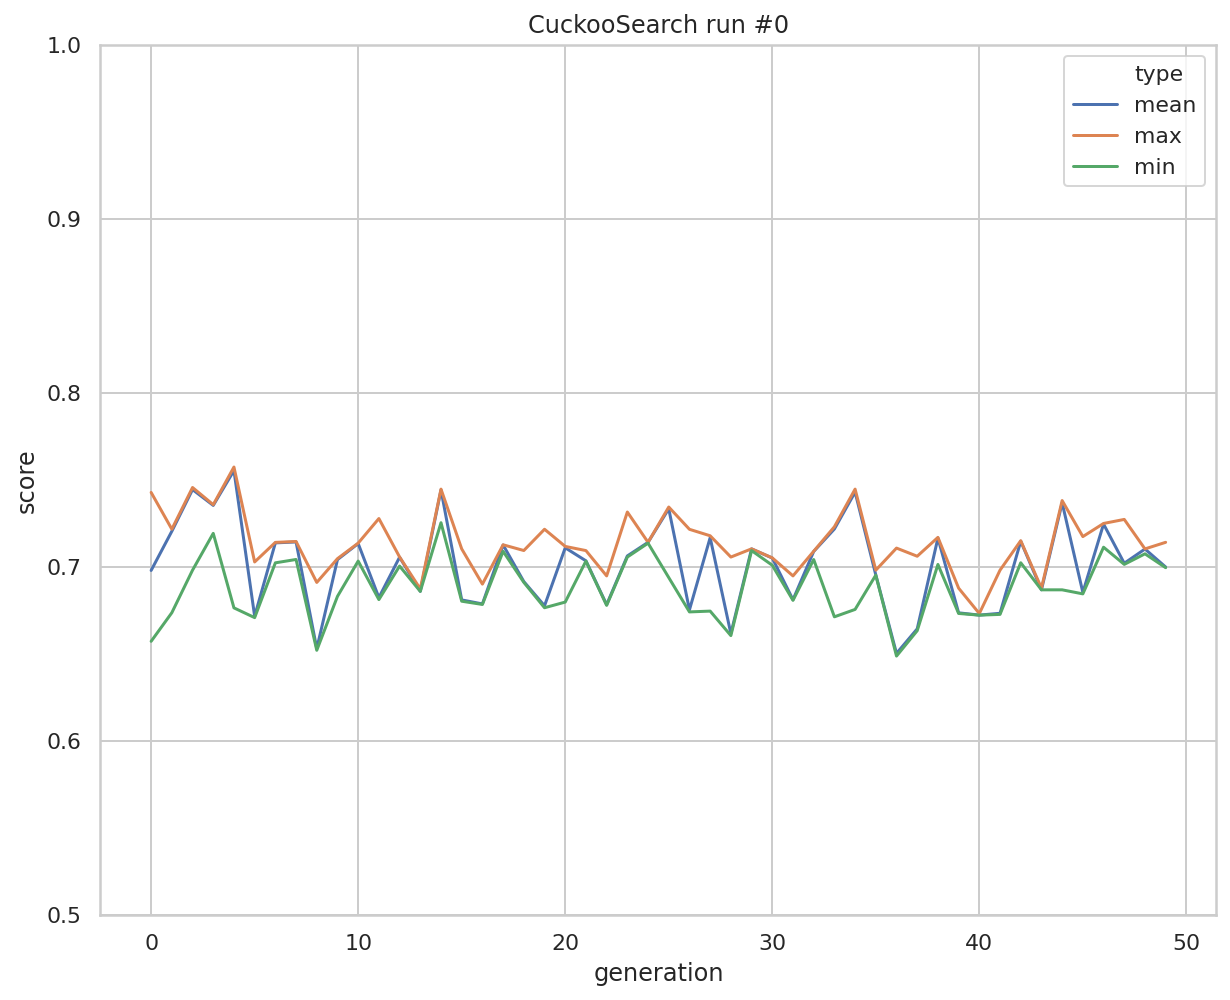

Score: 0.7572851620576866
Number of features selected: 116



--------------
Run 2
--------------


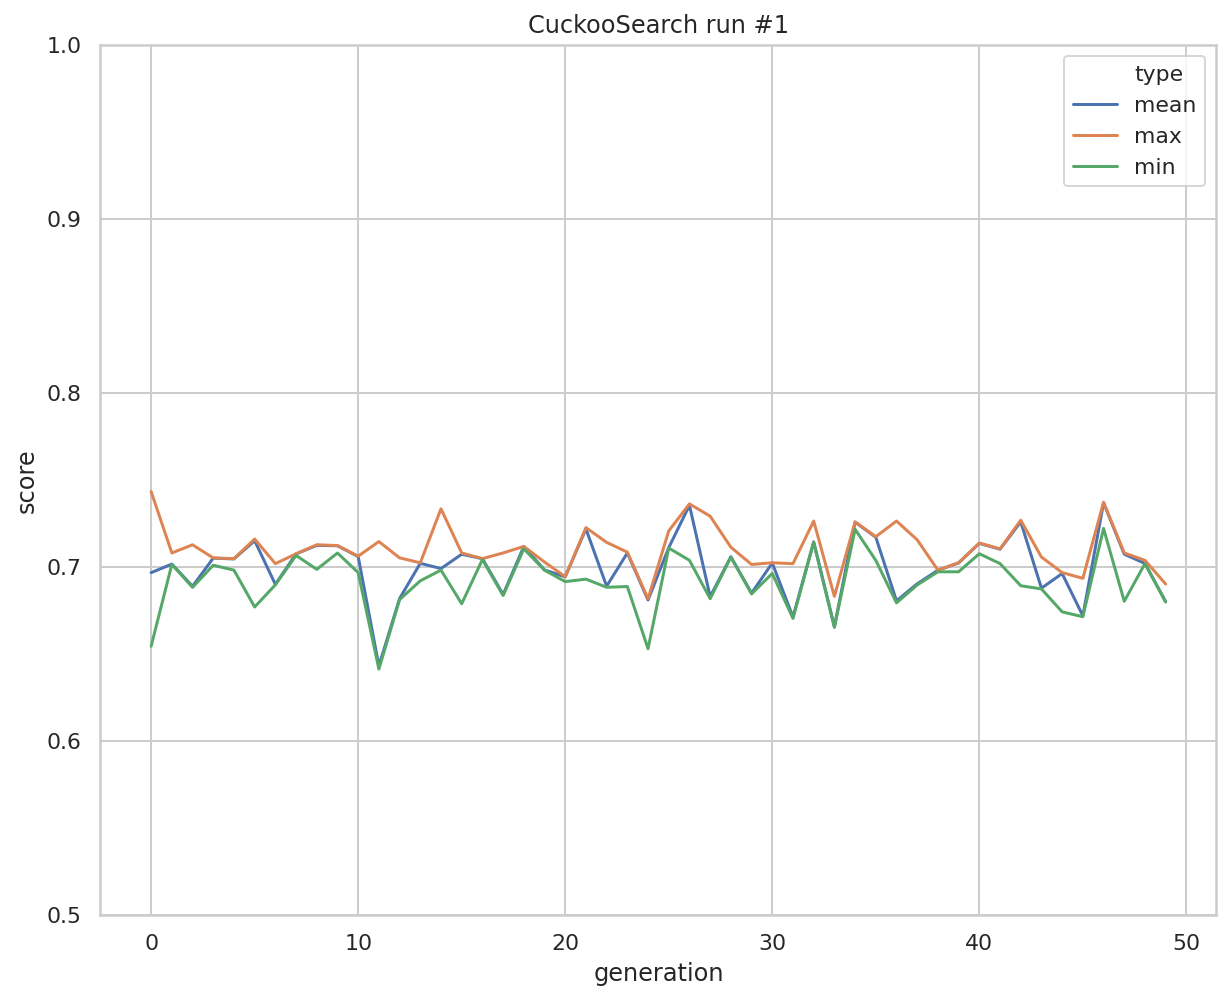

Score: 0.7431980374665478
Number of features selected: 123



--------------
Run 3
--------------


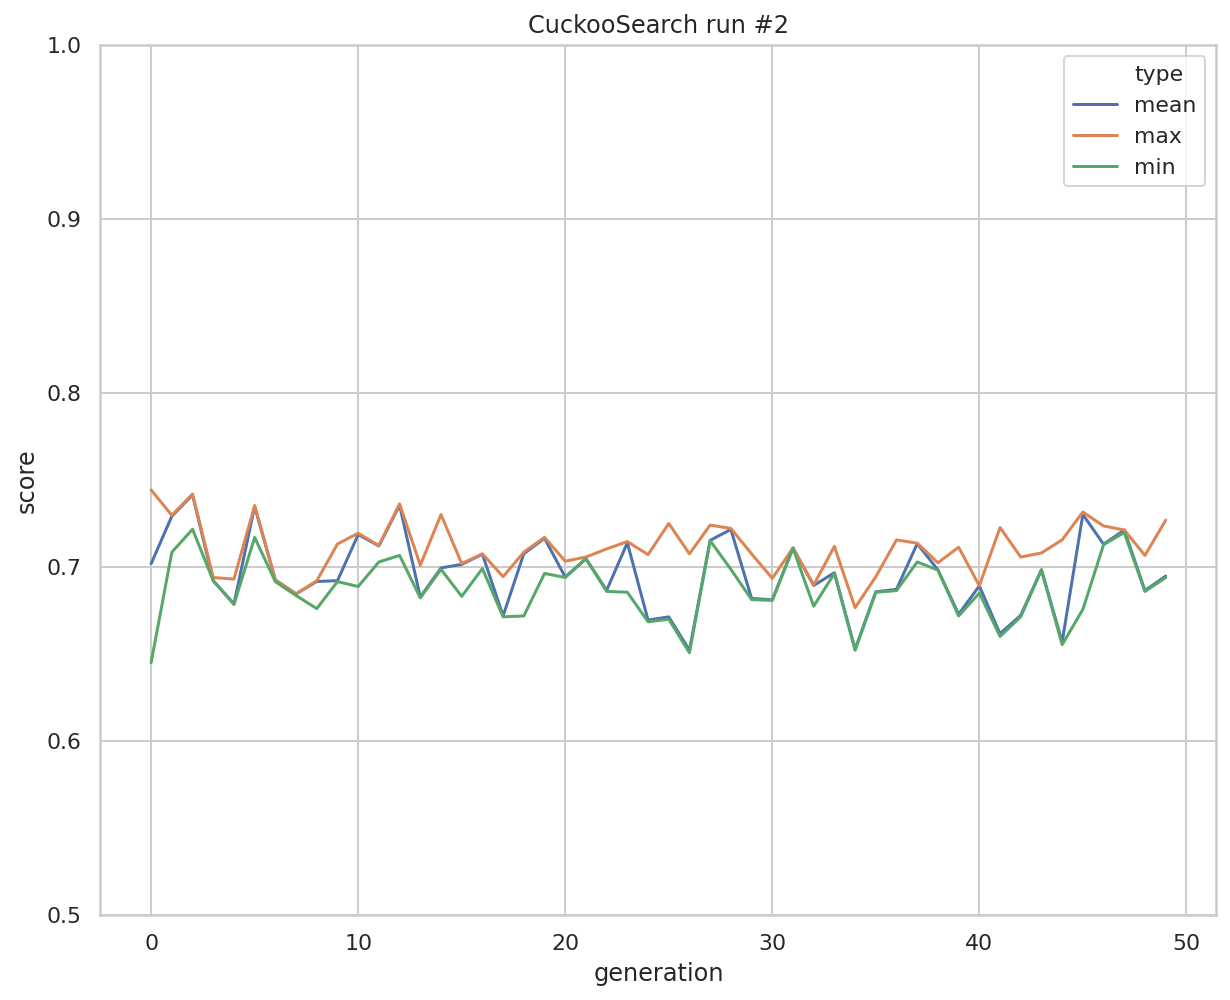

Score: 0.7441272673208446
Number of features selected: 120




Mean score of 3 runs: 0.7482034889483596



Best score of 3 runs: 0.7572851620576866
Number of features selected: 116



CuckooSearch
population_size=50
number_of_generations=50
--------------
Run 1
--------------


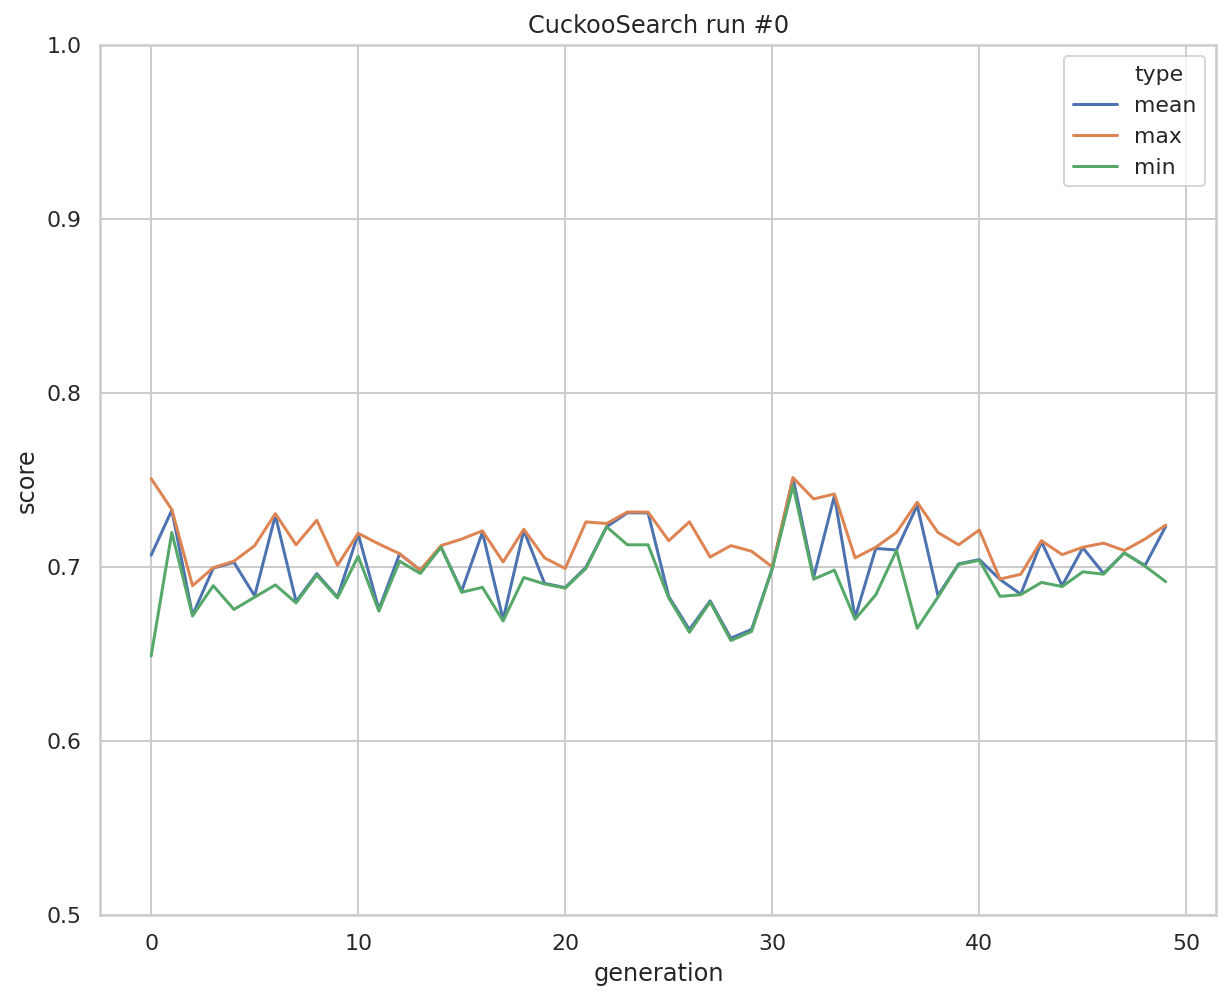

Score: 0.7511708296164139
Number of features selected: 133



--------------
Run 2
--------------


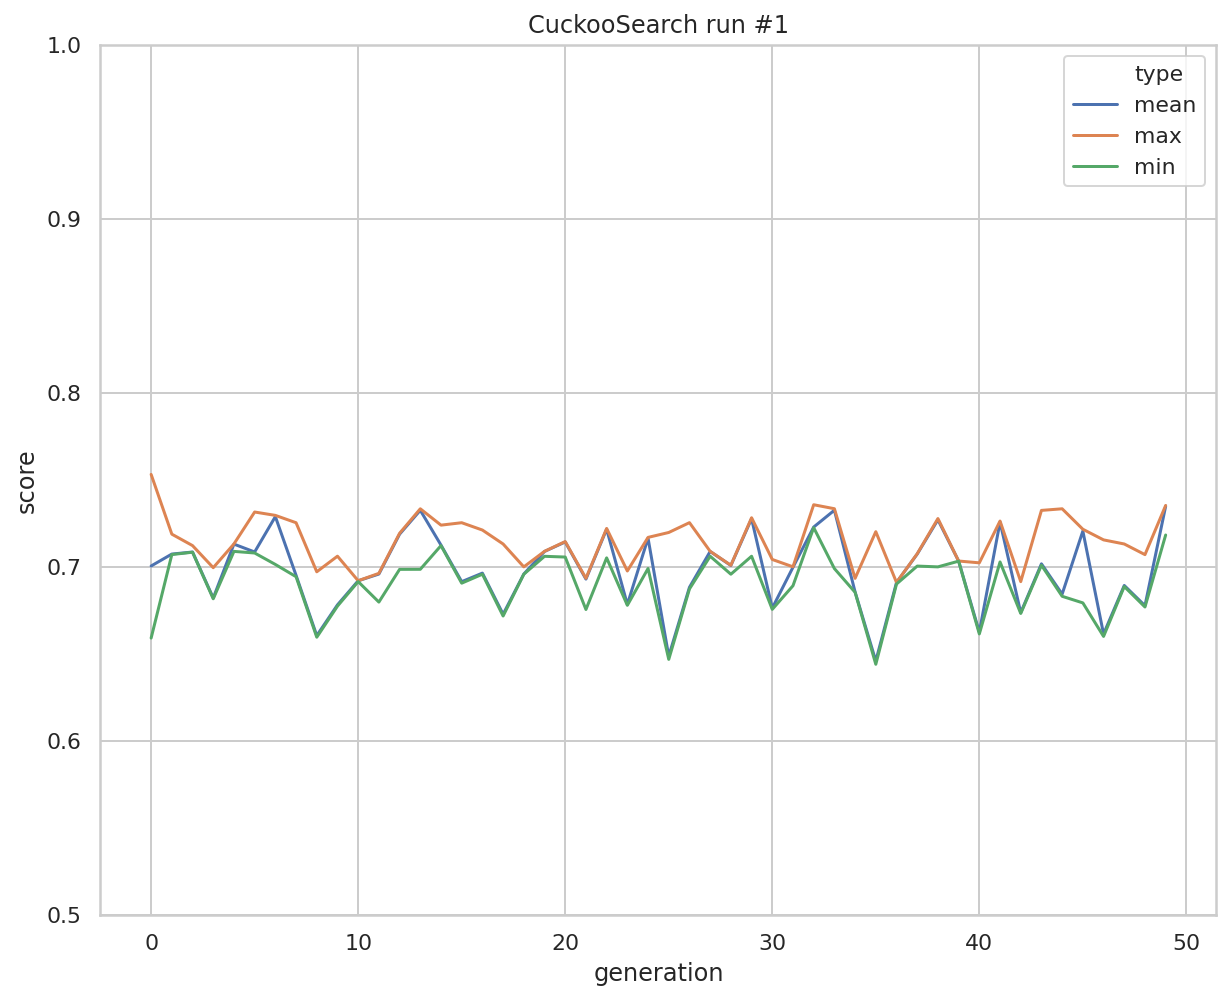

Score: 0.7530664585191793
Number of features selected: 121



--------------
Run 3
--------------


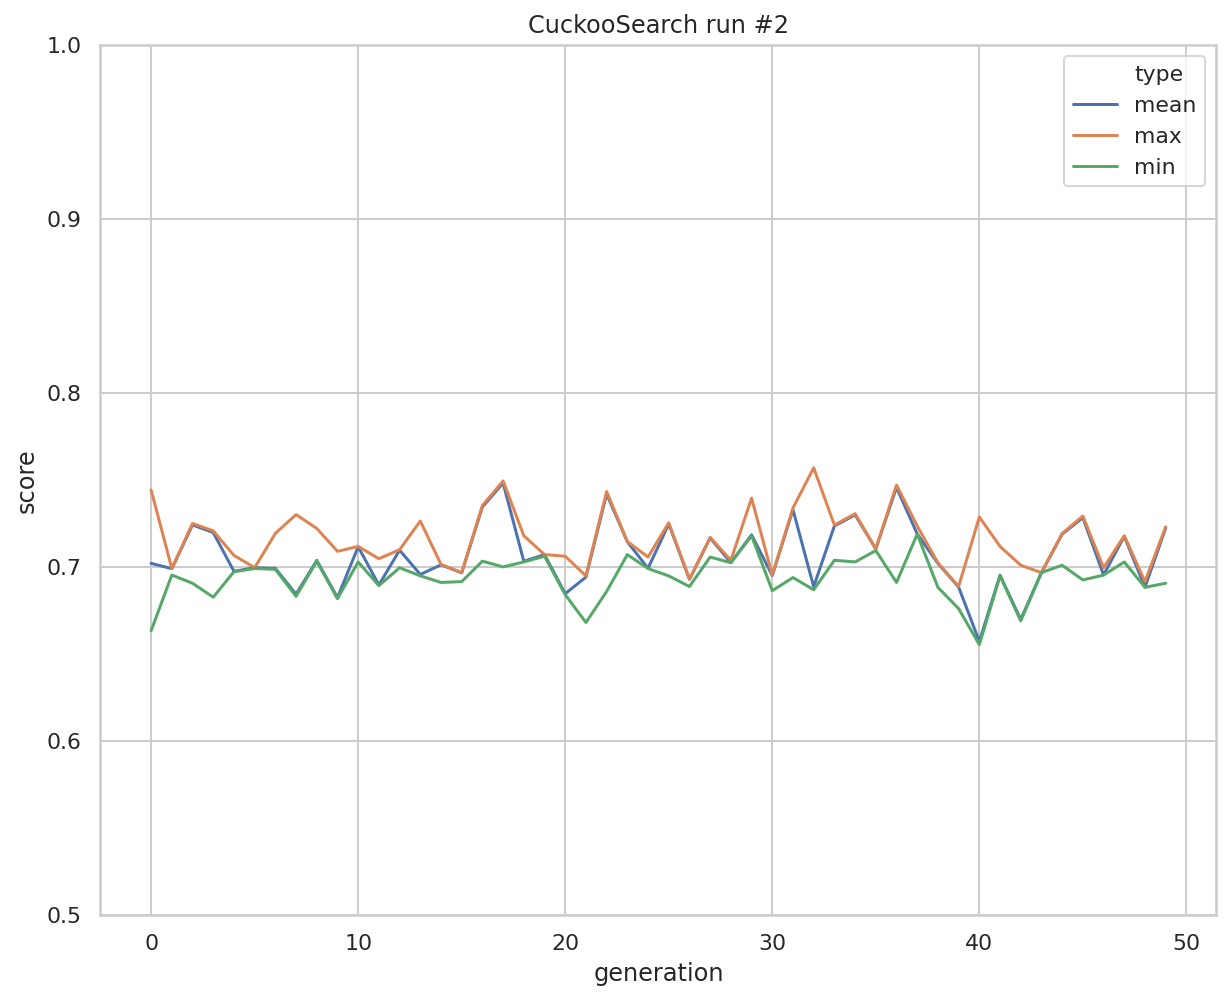

Score: 0.7568205471305381
Number of features selected: 223




Mean score of 3 runs: 0.7536859450887105



Best score of 3 runs: 0.7568205471305381
Number of features selected: 223



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The best score is 0.7610640301318269 with population_size=10

CPU times: user 10min 38s, sys: 2.56 s, total: 10min 40s
Wall time: 10min 41s


In [15]:
%%time

from NiaPy.algorithms.basic import CuckooSearch

run_experiment(CuckooSearch())

### Bat Algorithm

[Bat Algorithm](https://github.com/NiaOrg/NiaPy/blob/master/NiaPy/algorithms/basic/ba.py) default parameters:
- A = 0.5
- r = 0.5
- Qmin = 0.0
- Qmax = 2.0

BatAlgorithm
population_size=10
number_of_generations=50
--------------
Run 1
--------------


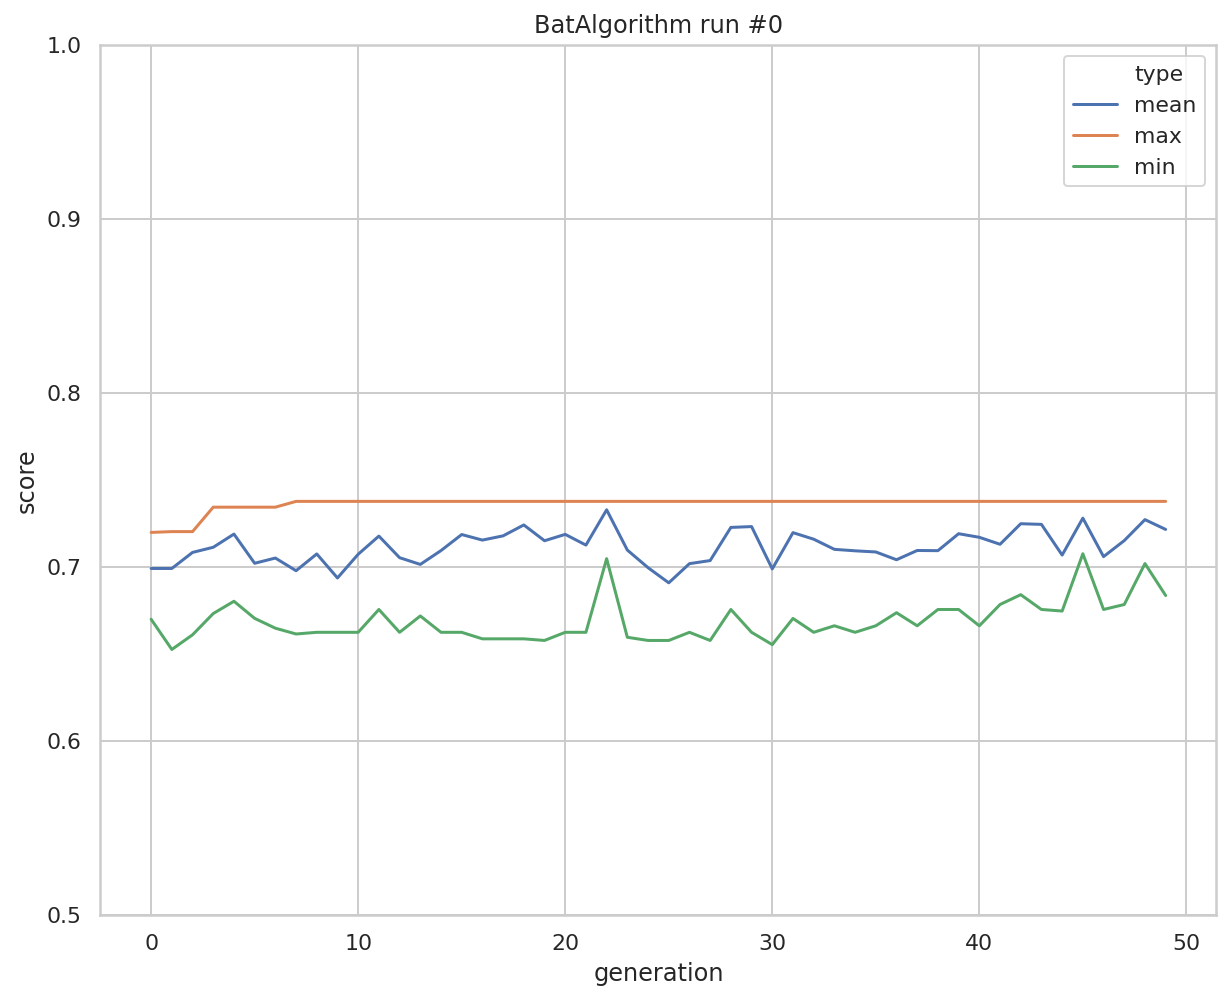

Score: 0.7375483199524234
Number of features selected: 132



--------------
Run 2
--------------


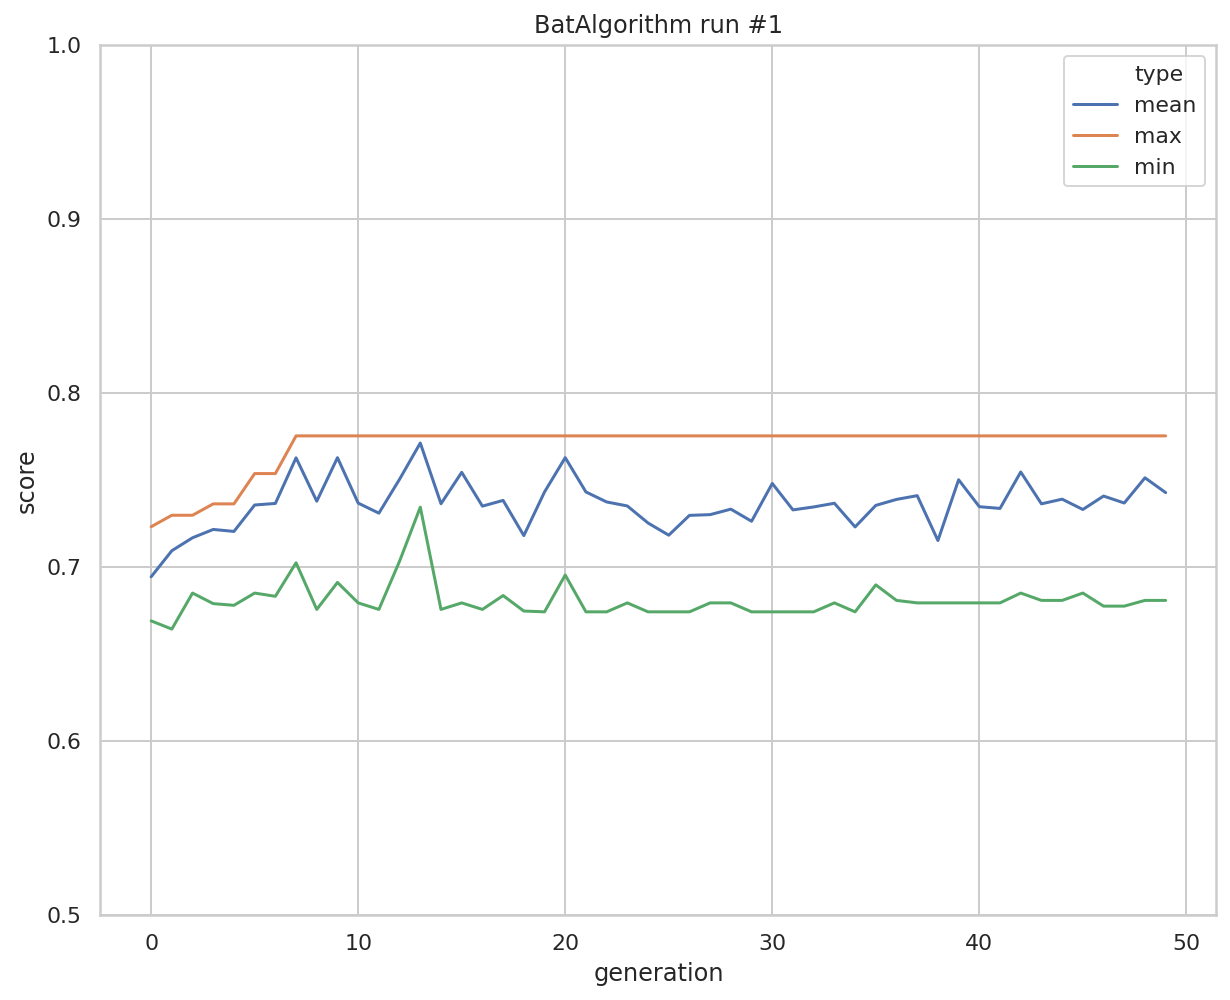

Score: 0.7752007136485282
Number of features selected: 124



--------------
Run 3
--------------


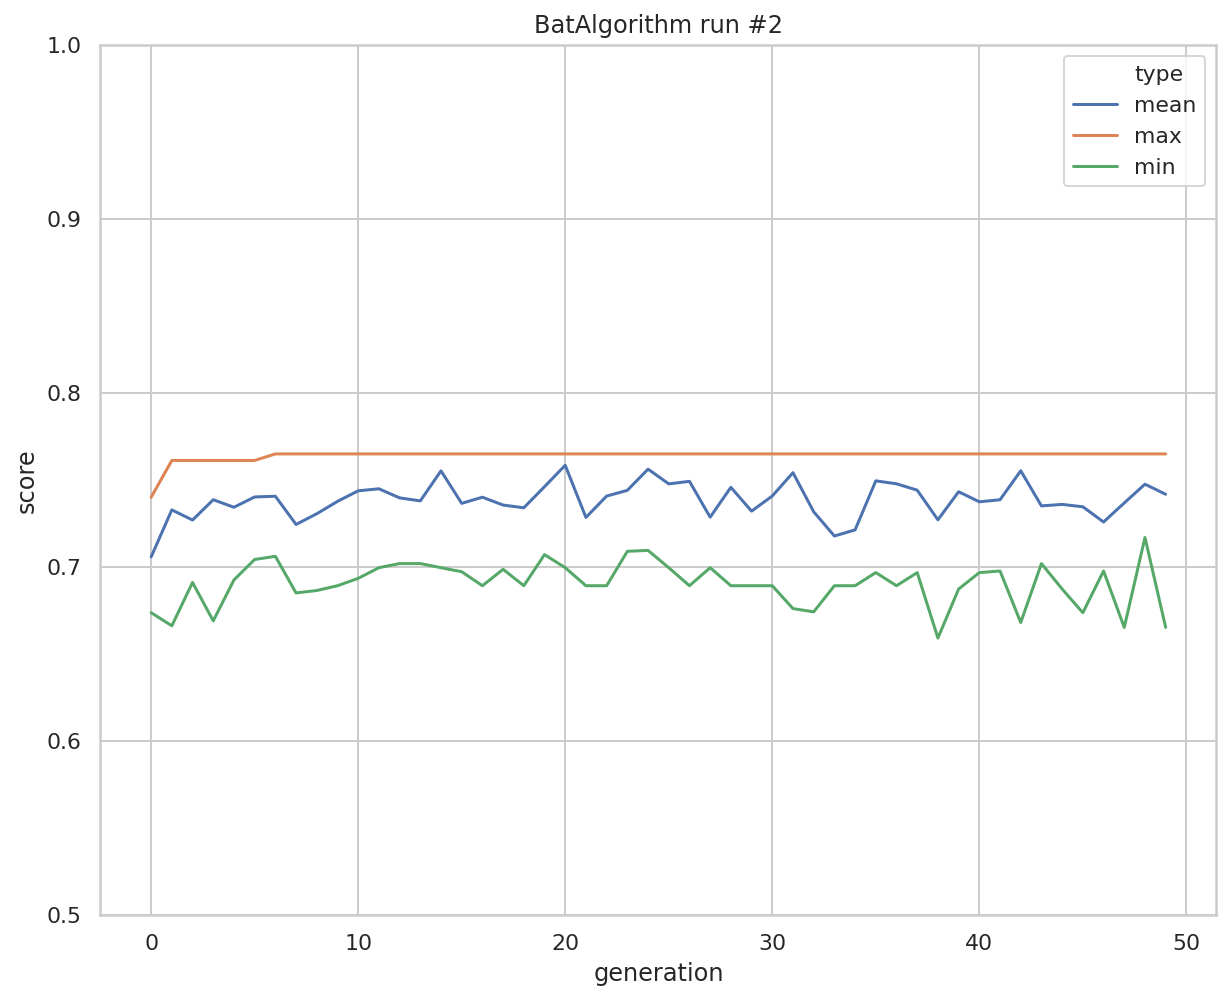

Score: 0.7648305084745763
Number of features selected: 118




Mean score of 3 runs: 0.7591931806918426



Best score of 3 runs: 0.7752007136485282
Number of features selected: 124



BatAlgorithm
population_size=25
number_of_generations=50
--------------
Run 1
--------------


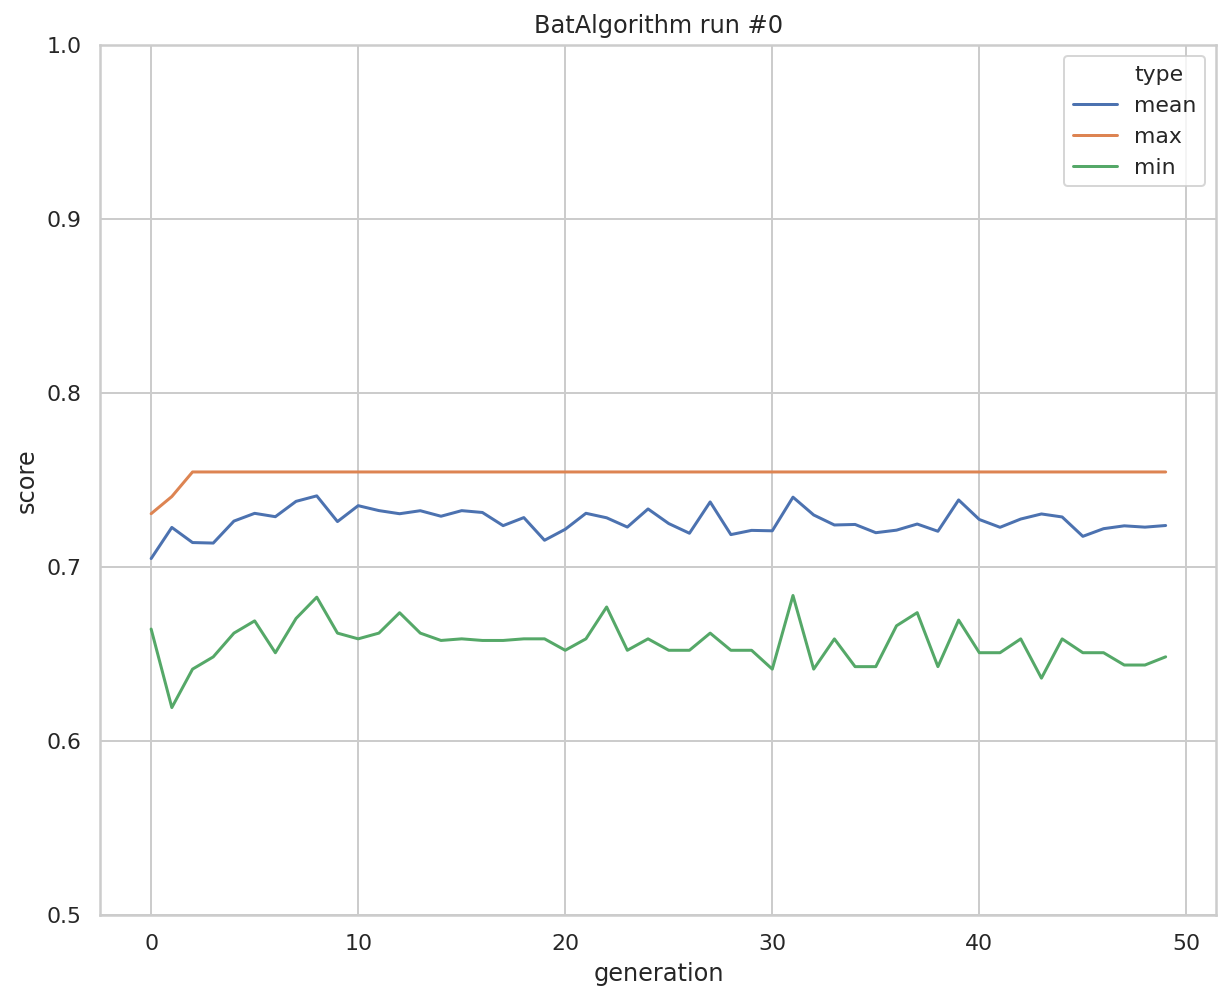

Score: 0.7544603033006244
Number of features selected: 130



--------------
Run 2
--------------


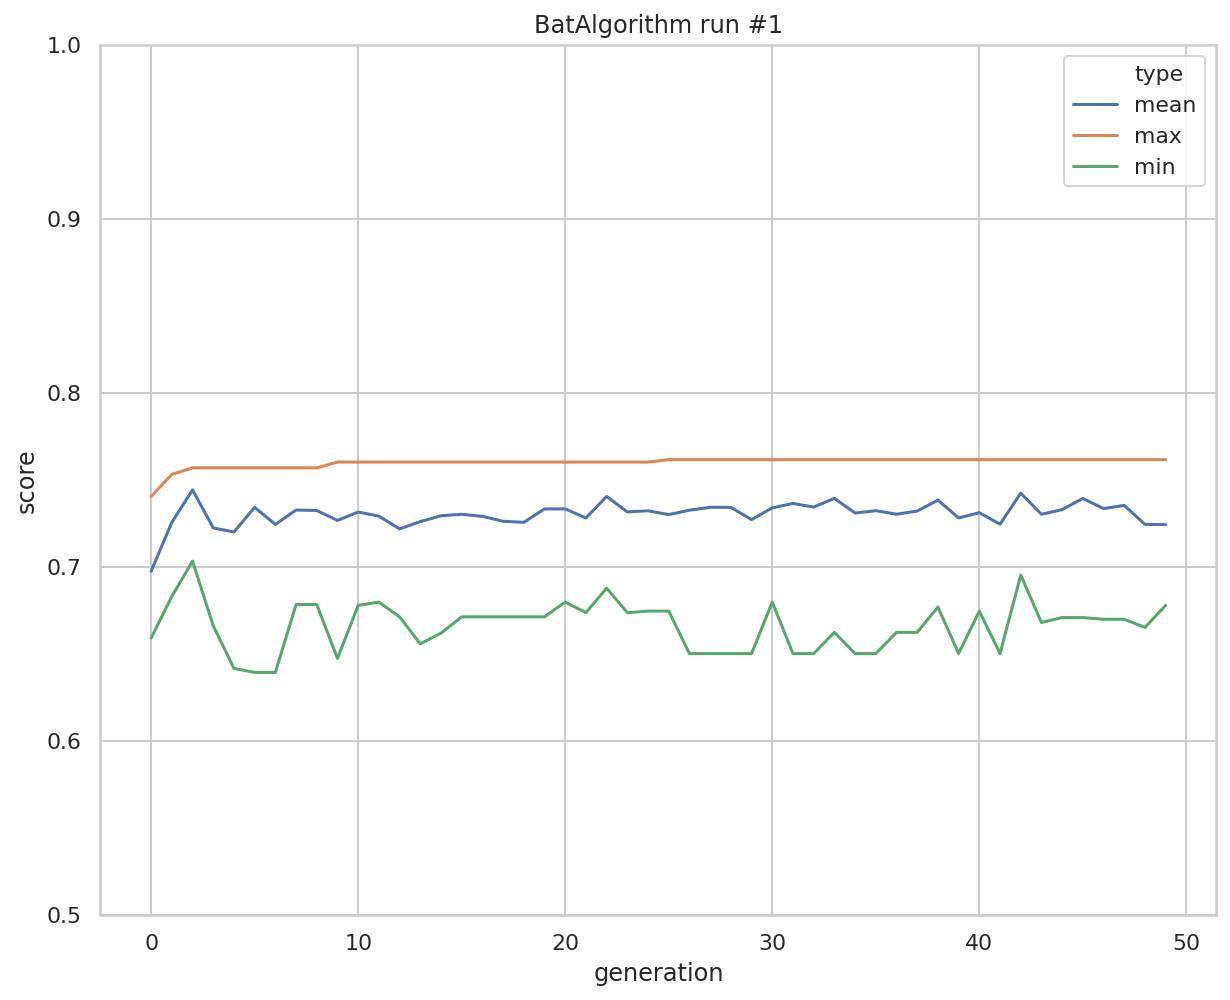

Score: 0.7615410347903657
Number of features selected: 108



--------------
Run 3
--------------


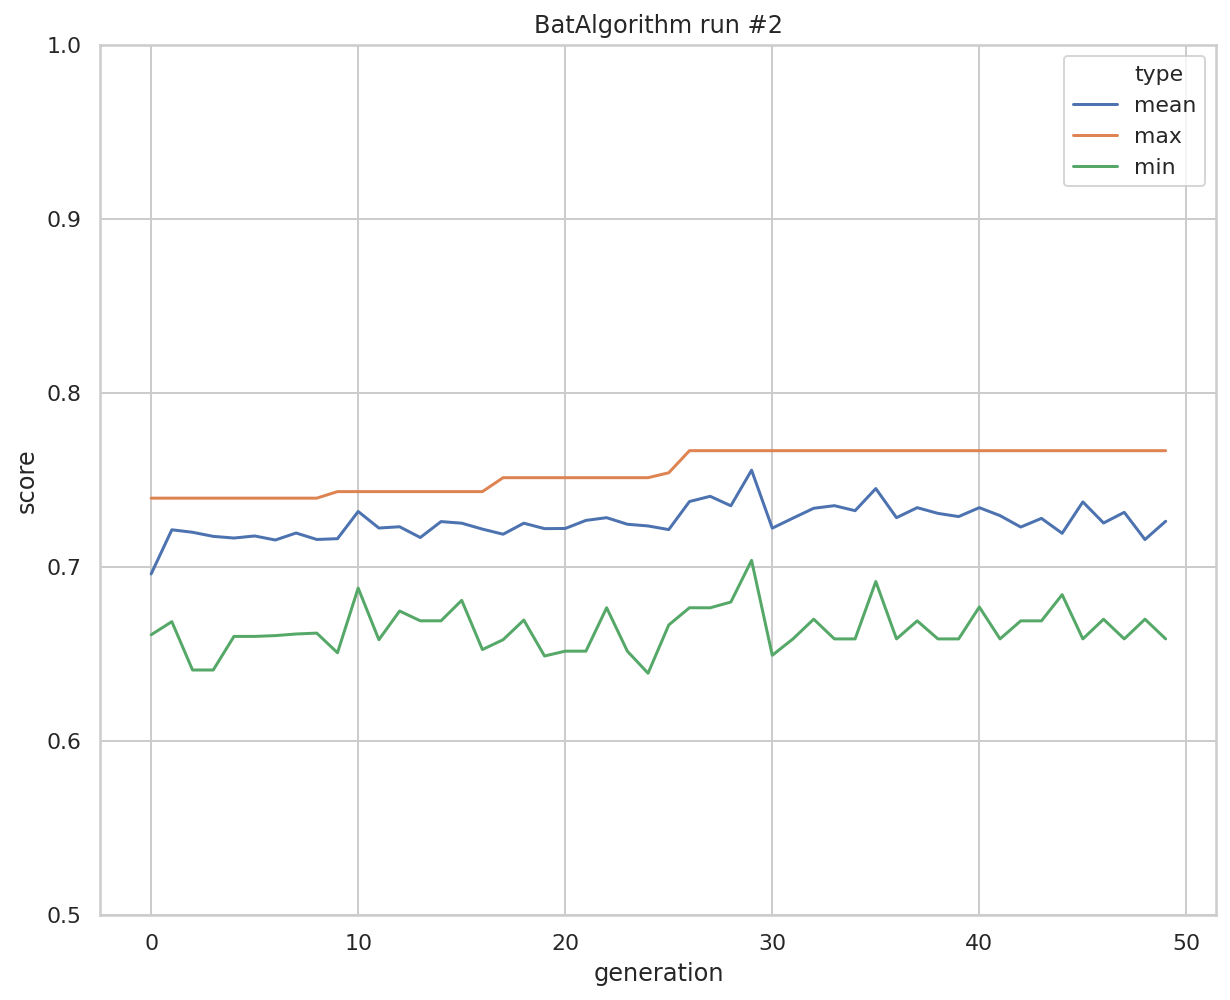

Score: 0.7666889681831698
Number of features selected: 124




Mean score of 3 runs: 0.7608967687580533



Best score of 3 runs: 0.7666889681831698
Number of features selected: 124



BatAlgorithm
population_size=50
number_of_generations=50
--------------
Run 1
--------------


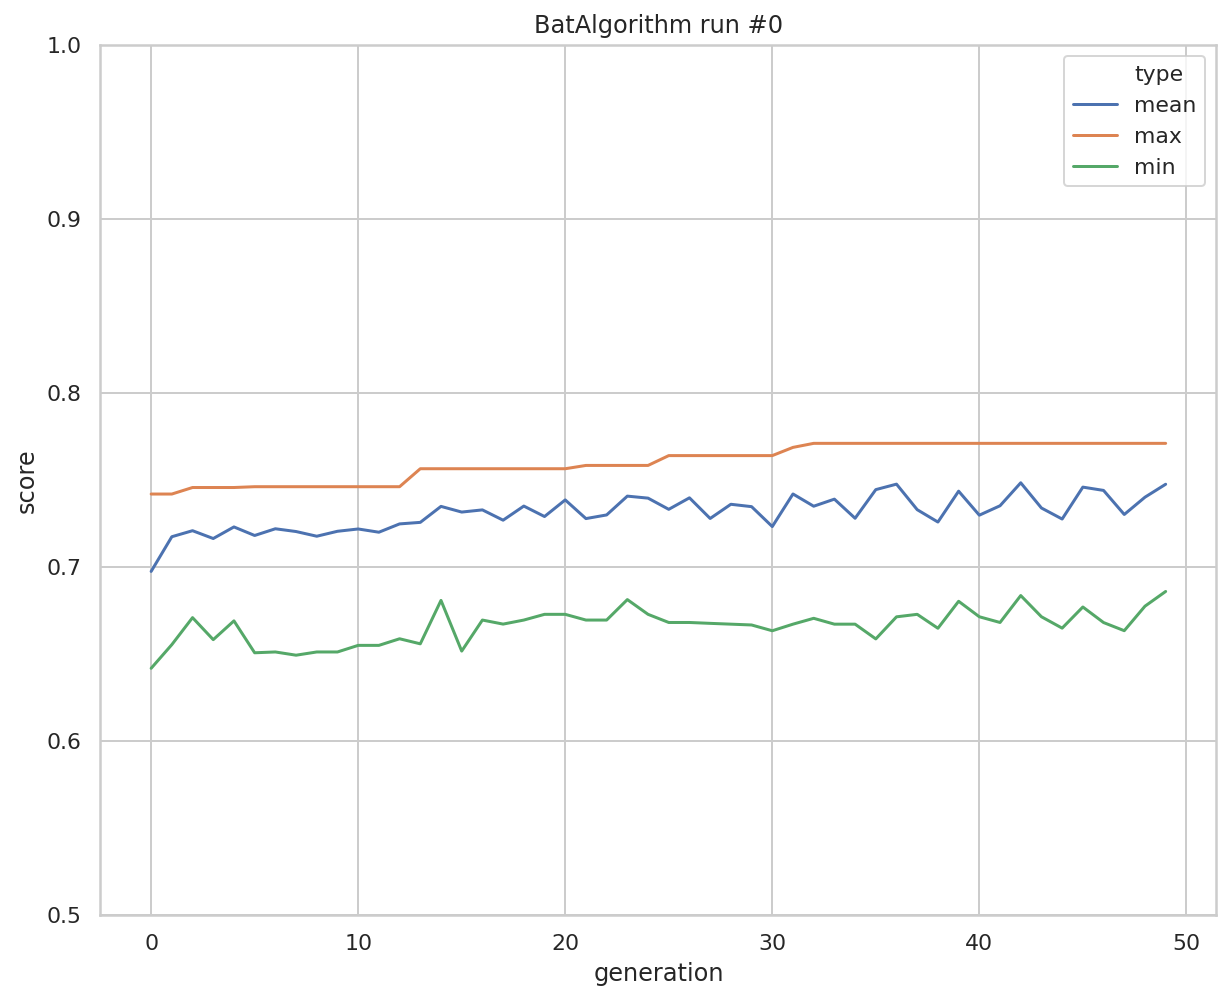

Score: 0.7709076717216771
Number of features selected: 115



--------------
Run 2
--------------


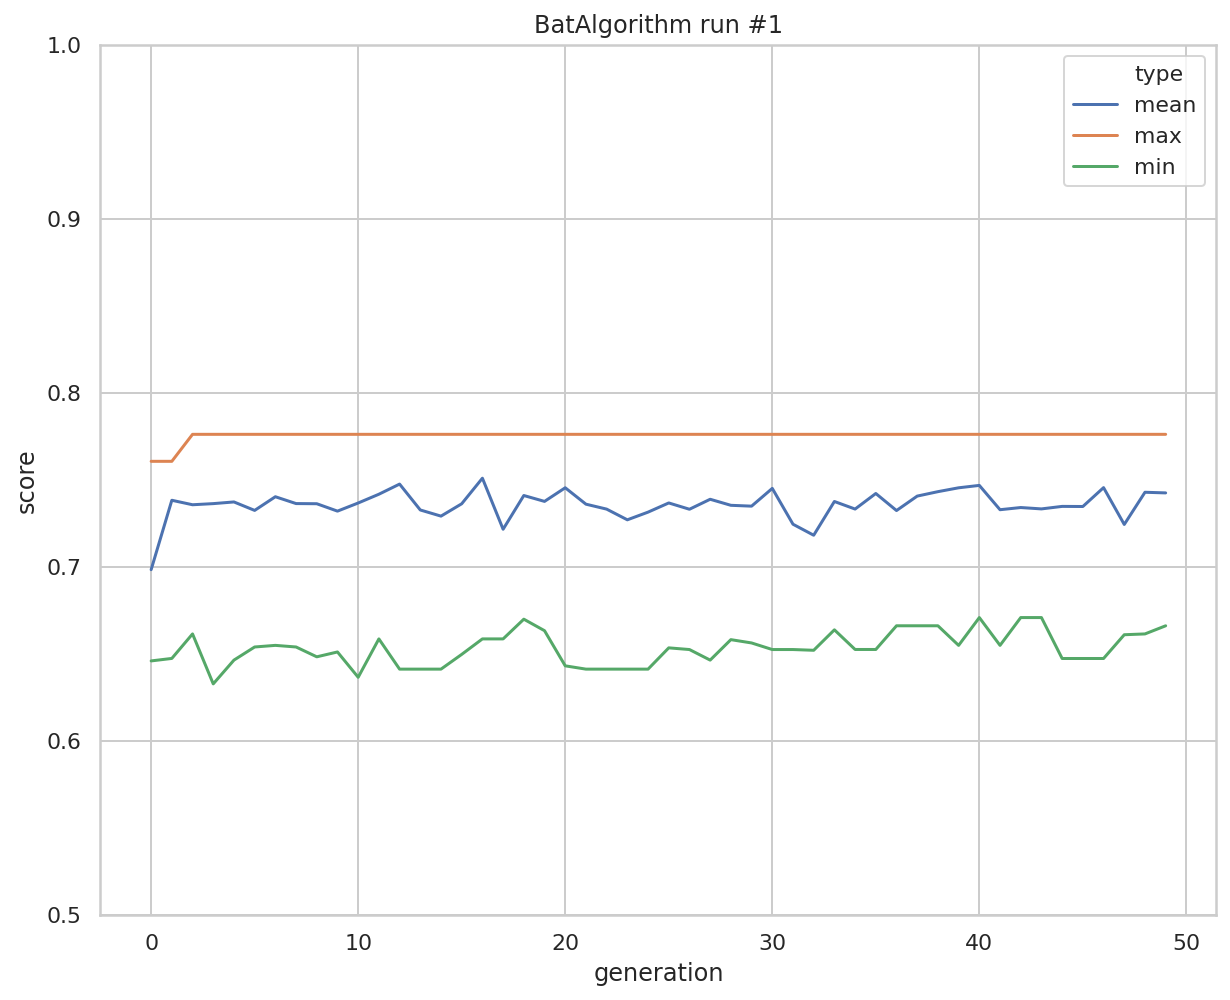

Score: 0.776092774308653
Number of features selected: 121



--------------
Run 3
--------------


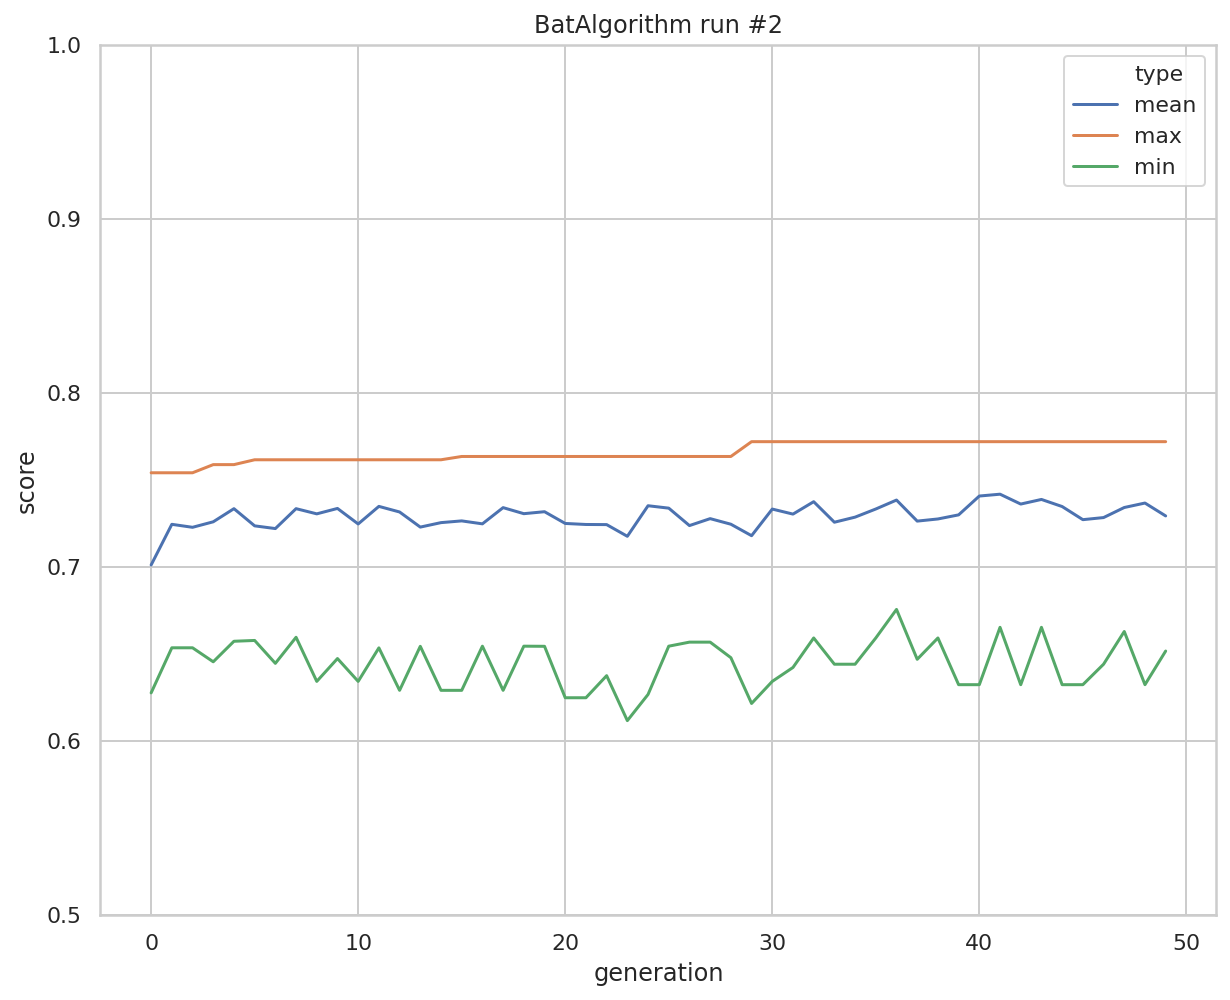

Score: 0.7718740707701458
Number of features selected: 129




Mean score of 3 runs: 0.7729581722668253



Best score of 3 runs: 0.776092774308653
Number of features selected: 121



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The best score is 0.7729581722668253 with population_size=50

CPU times: user 8min 5s, sys: 2.68 s, total: 8min 7s
Wall time: 8min 8s


In [16]:
%%time

from NiaPy.algorithms.basic import BatAlgorithm

run_experiment(BatAlgorithm())

### Flower Pollination Algorithm

[Flower Pollination Algorithm](https://github.com/NiaOrg/NiaPy/blob/master/NiaPy/algorithms/basic/fpa.py) default parameters:
- p = 0.35
- beta = 1.5

FlowerPollinationAlgorithm
population_size=10
number_of_generations=50
--------------
Run 1
--------------


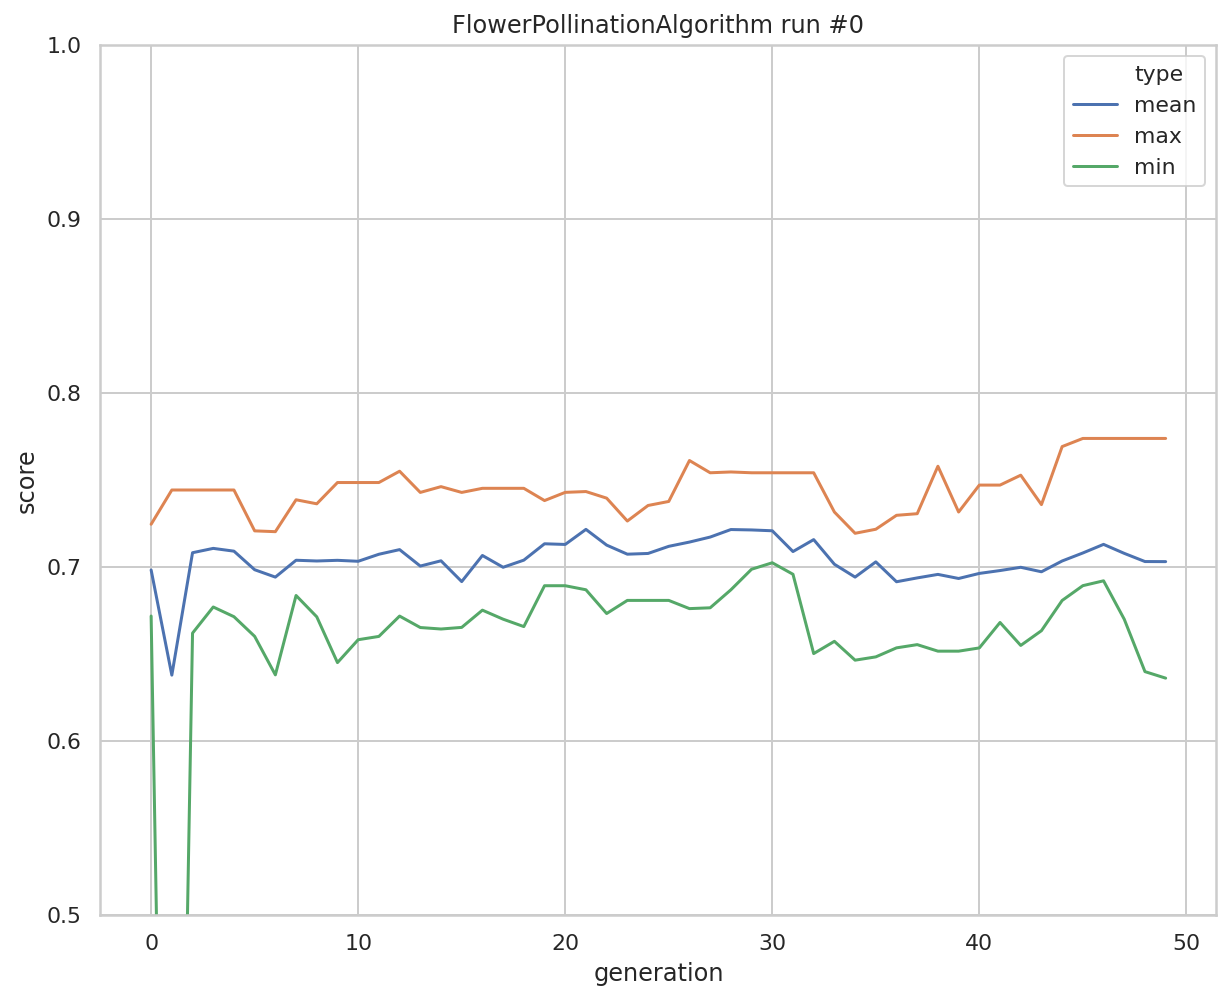

Score: 0.7737325304787391
Number of features selected: 120



--------------
Run 2
--------------


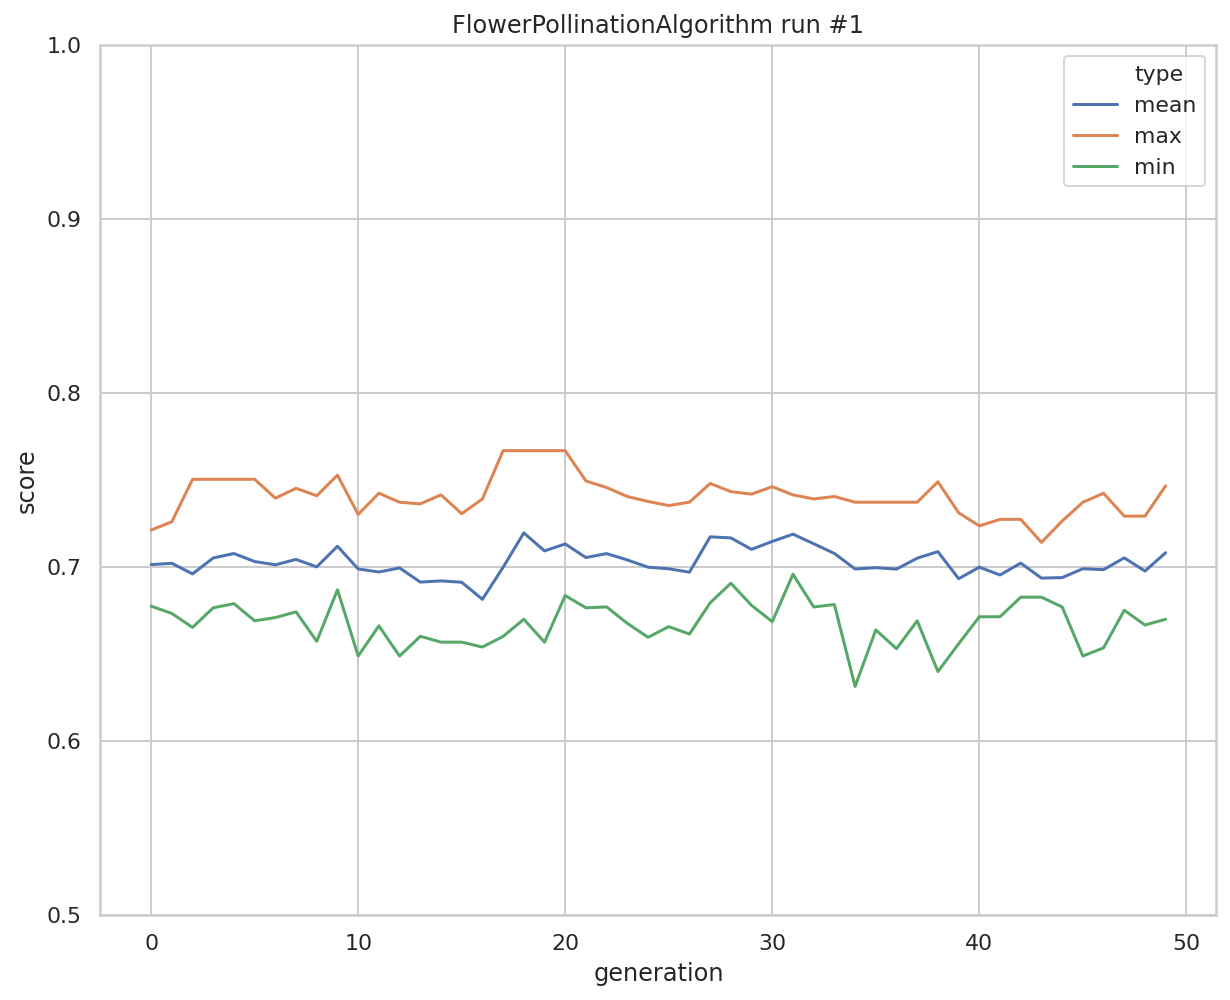

Score: 0.7666889681831698
Number of features selected: 114



--------------
Run 3
--------------


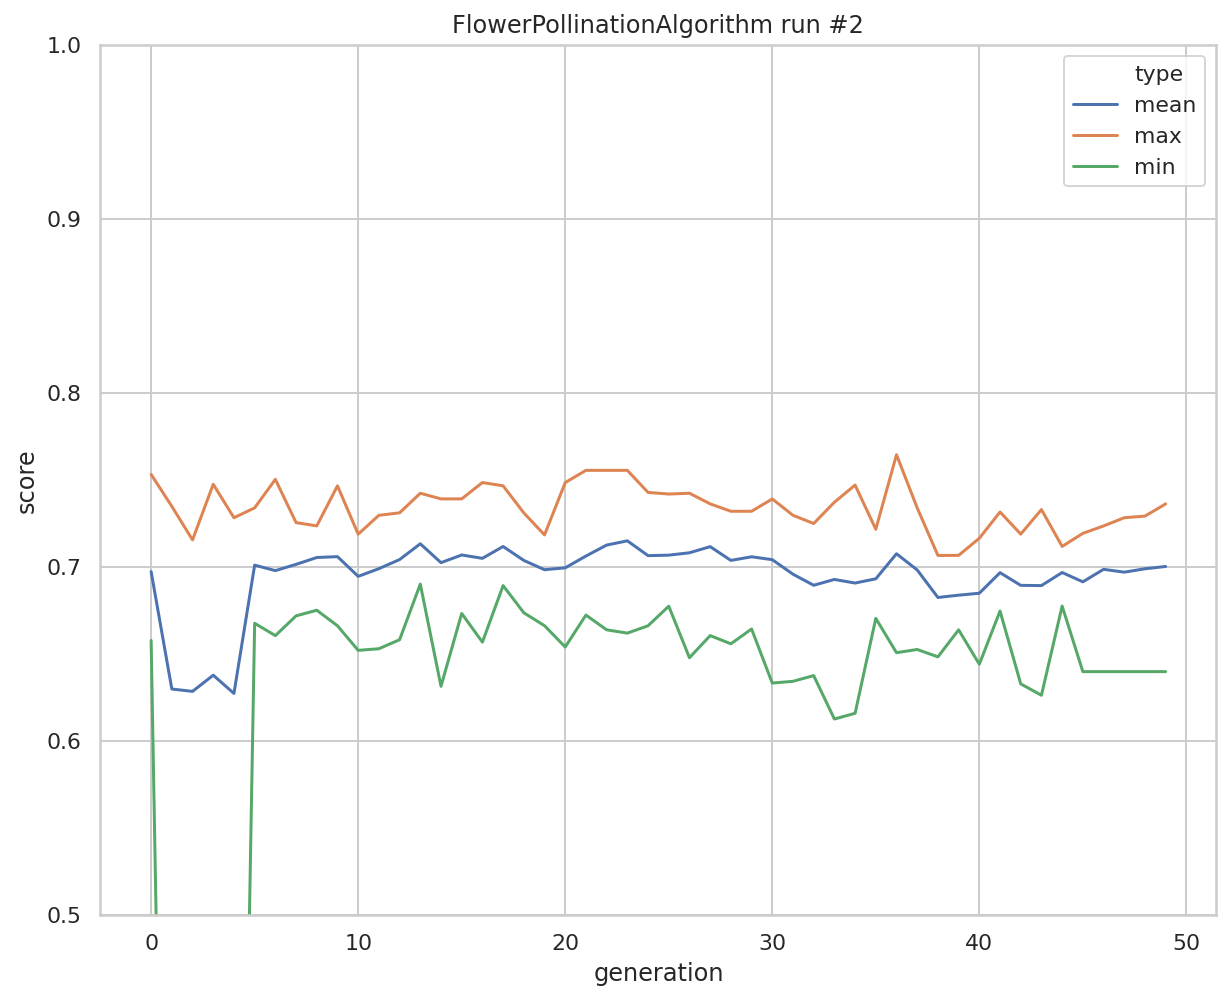

Score: 0.7643658935474279
Number of features selected: 119




Mean score of 3 runs: 0.7682624640697789



Best score of 3 runs: 0.7737325304787391
Number of features selected: 120



FlowerPollinationAlgorithm
population_size=25
number_of_generations=50
--------------
Run 1
--------------


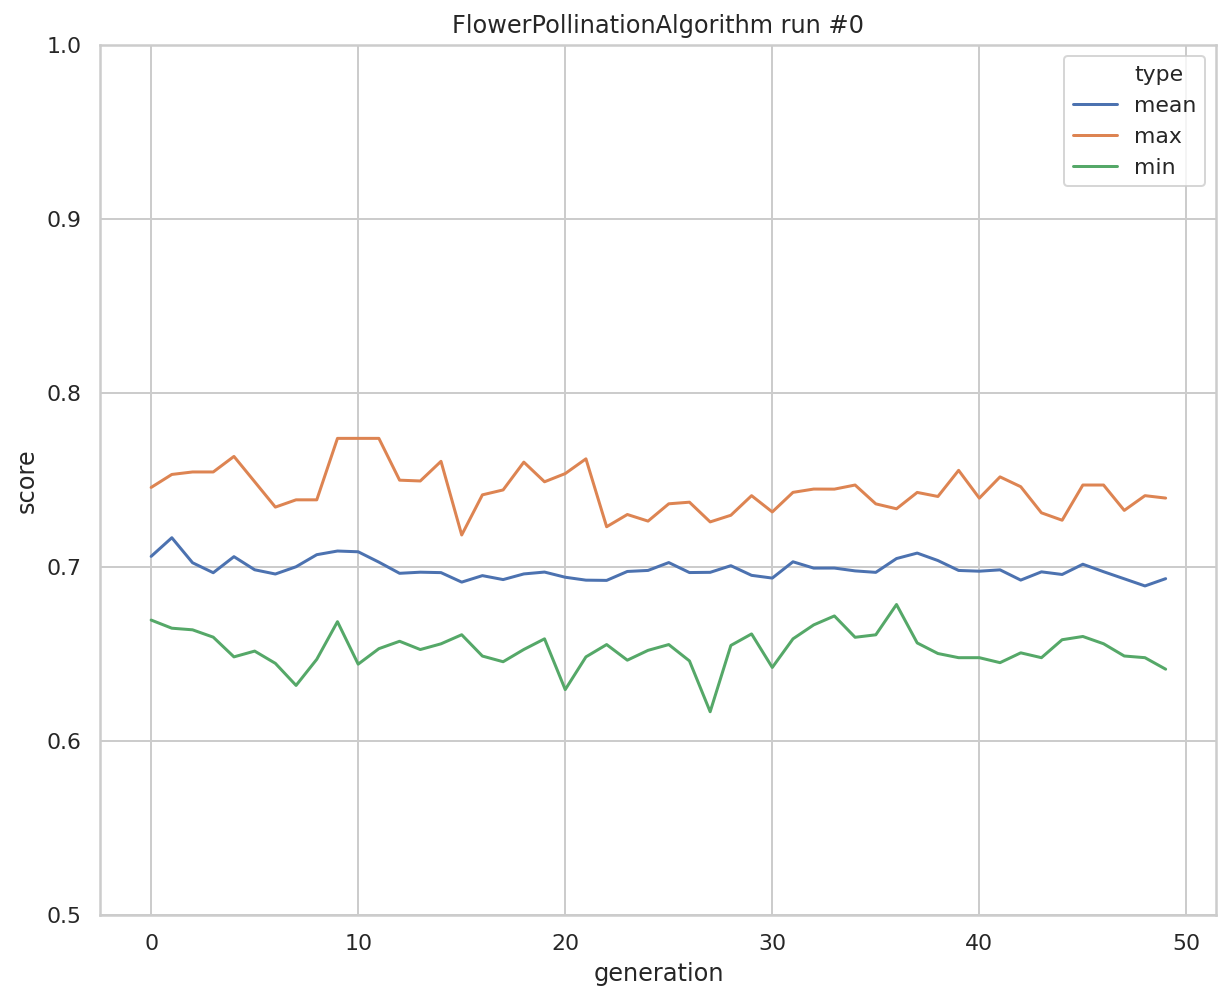

Score: 0.7737696996729111
Number of features selected: 117



--------------
Run 2
--------------


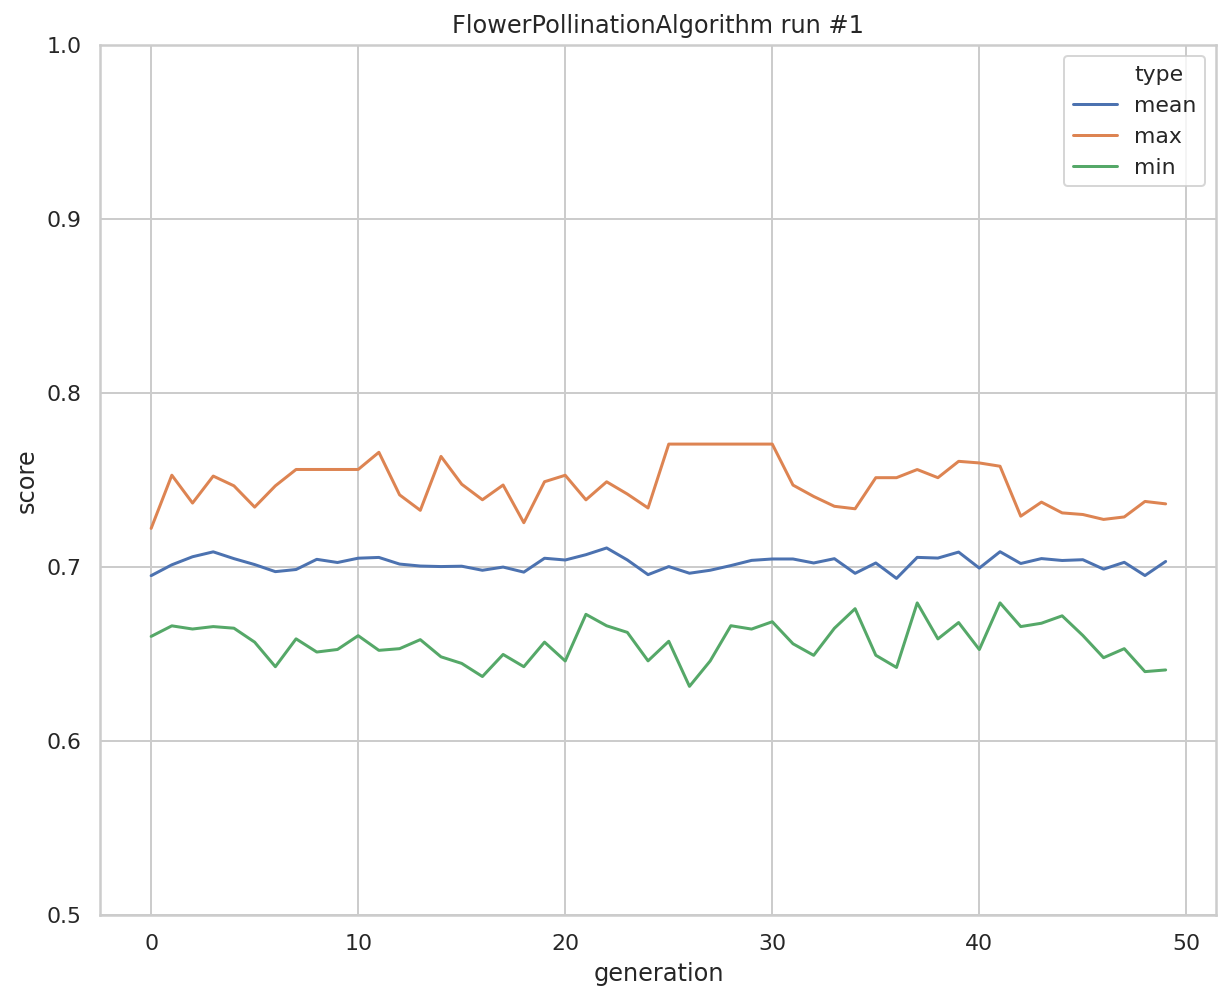

Score: 0.7704802259887006
Number of features selected: 120



--------------
Run 3
--------------


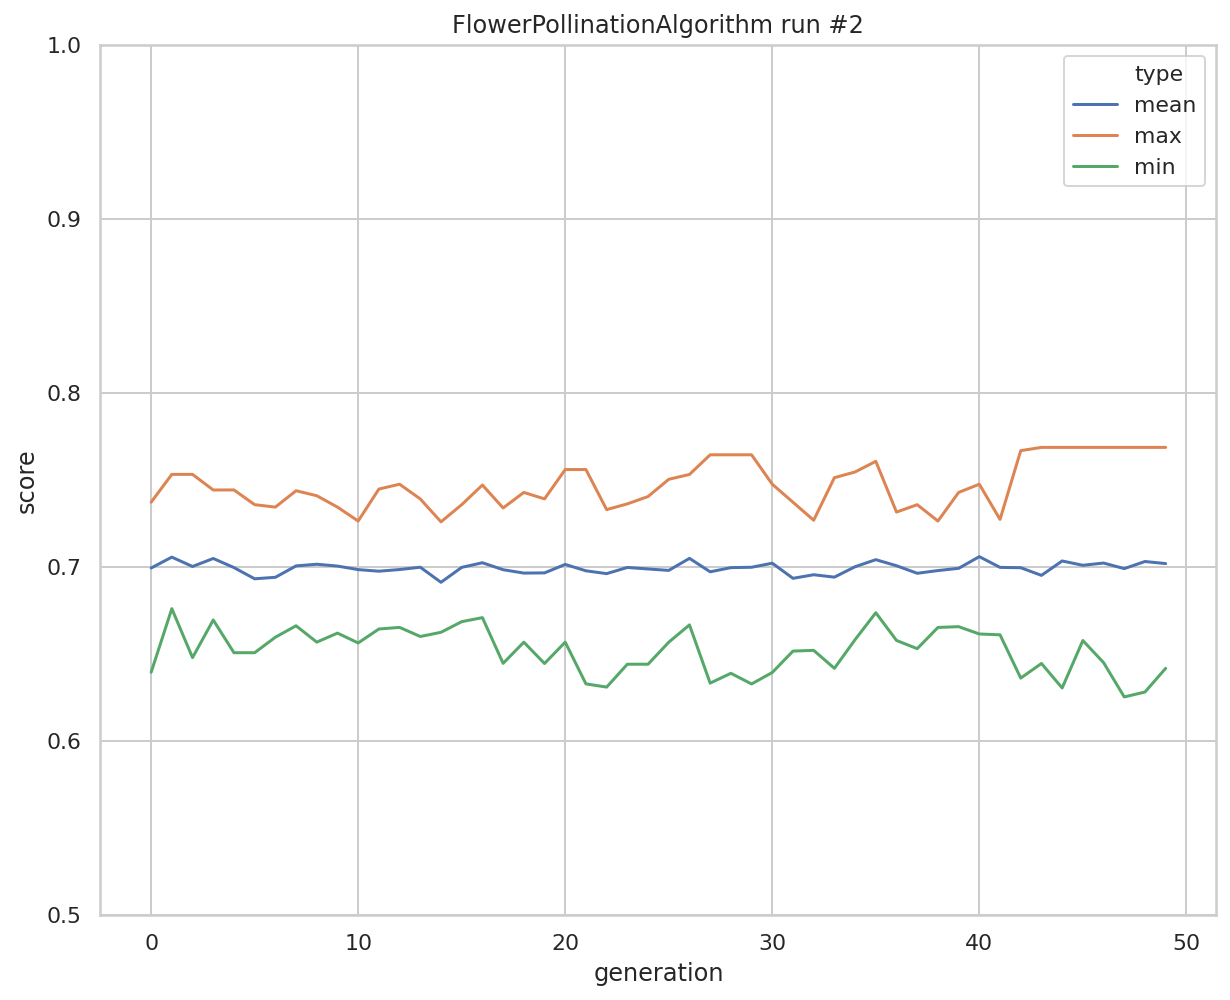

Score: 0.7685845970859352
Number of features selected: 115




Mean score of 3 runs: 0.7709448409158489



Best score of 3 runs: 0.7737696996729111
Number of features selected: 117



FlowerPollinationAlgorithm
population_size=50
number_of_generations=50
--------------
Run 1
--------------


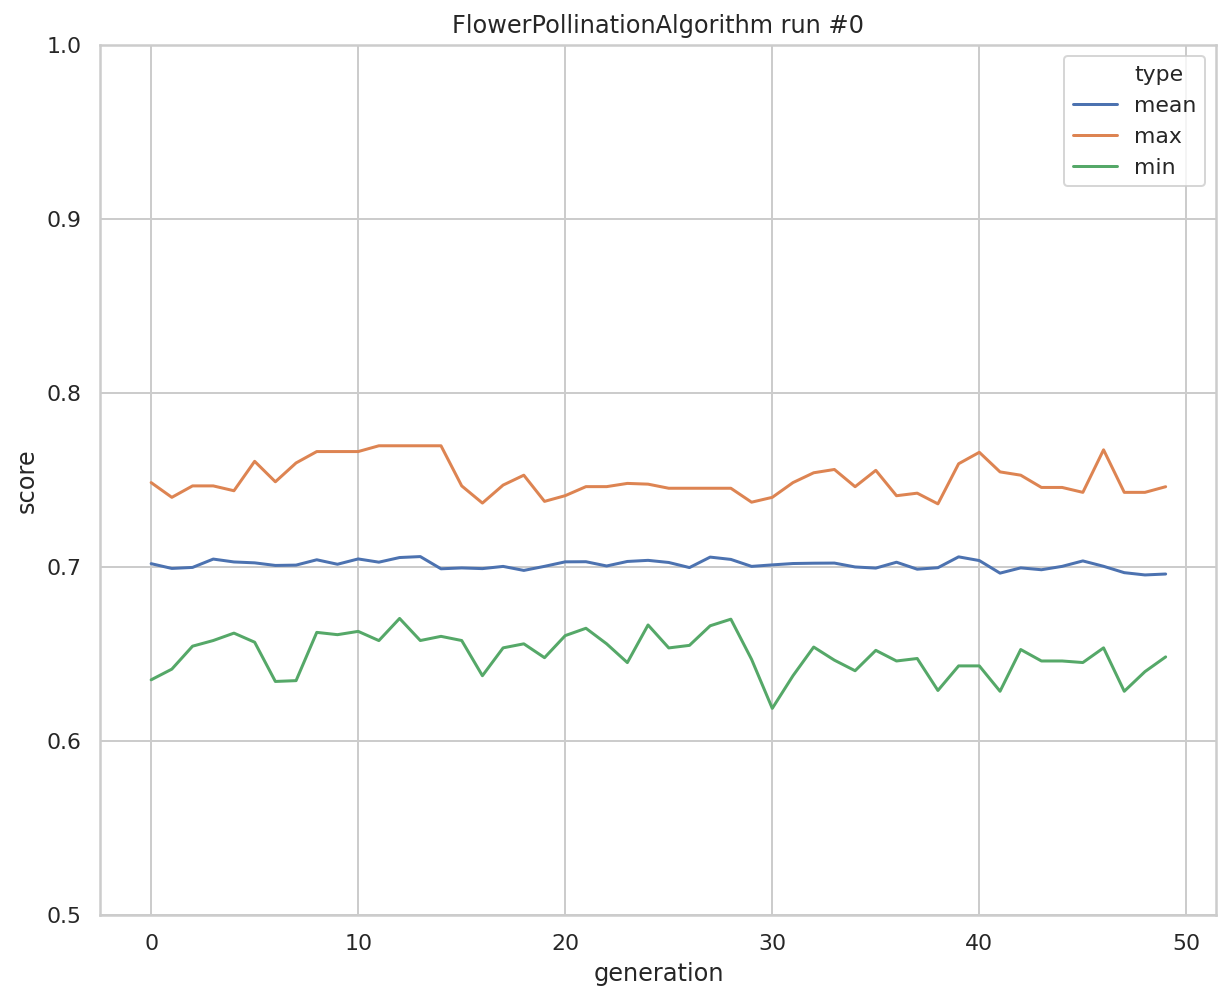

Score: 0.7695138269402318
Number of features selected: 116



--------------
Run 2
--------------


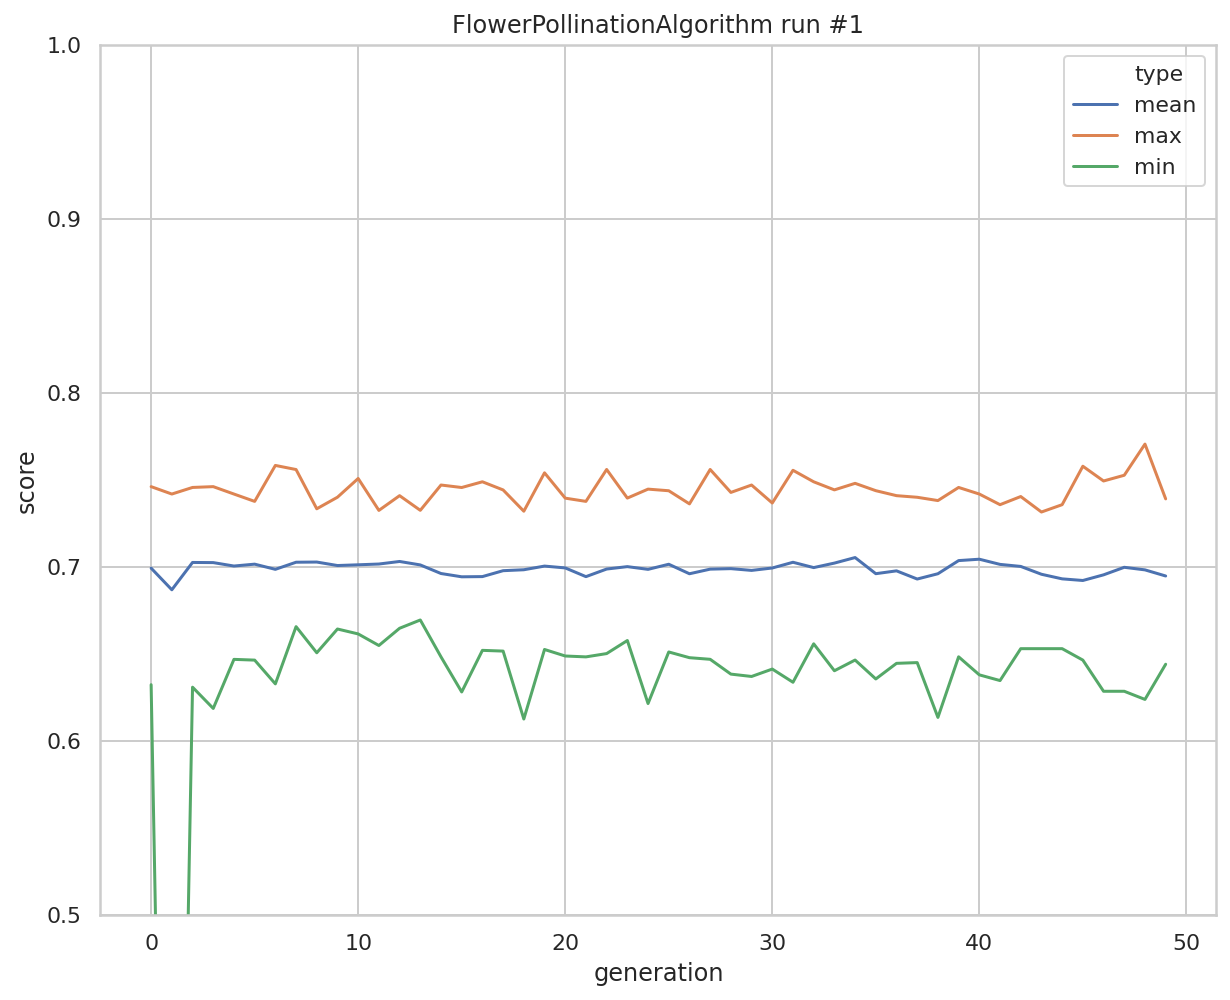

Score: 0.7704802259887006
Number of features selected: 112



--------------
Run 3
--------------


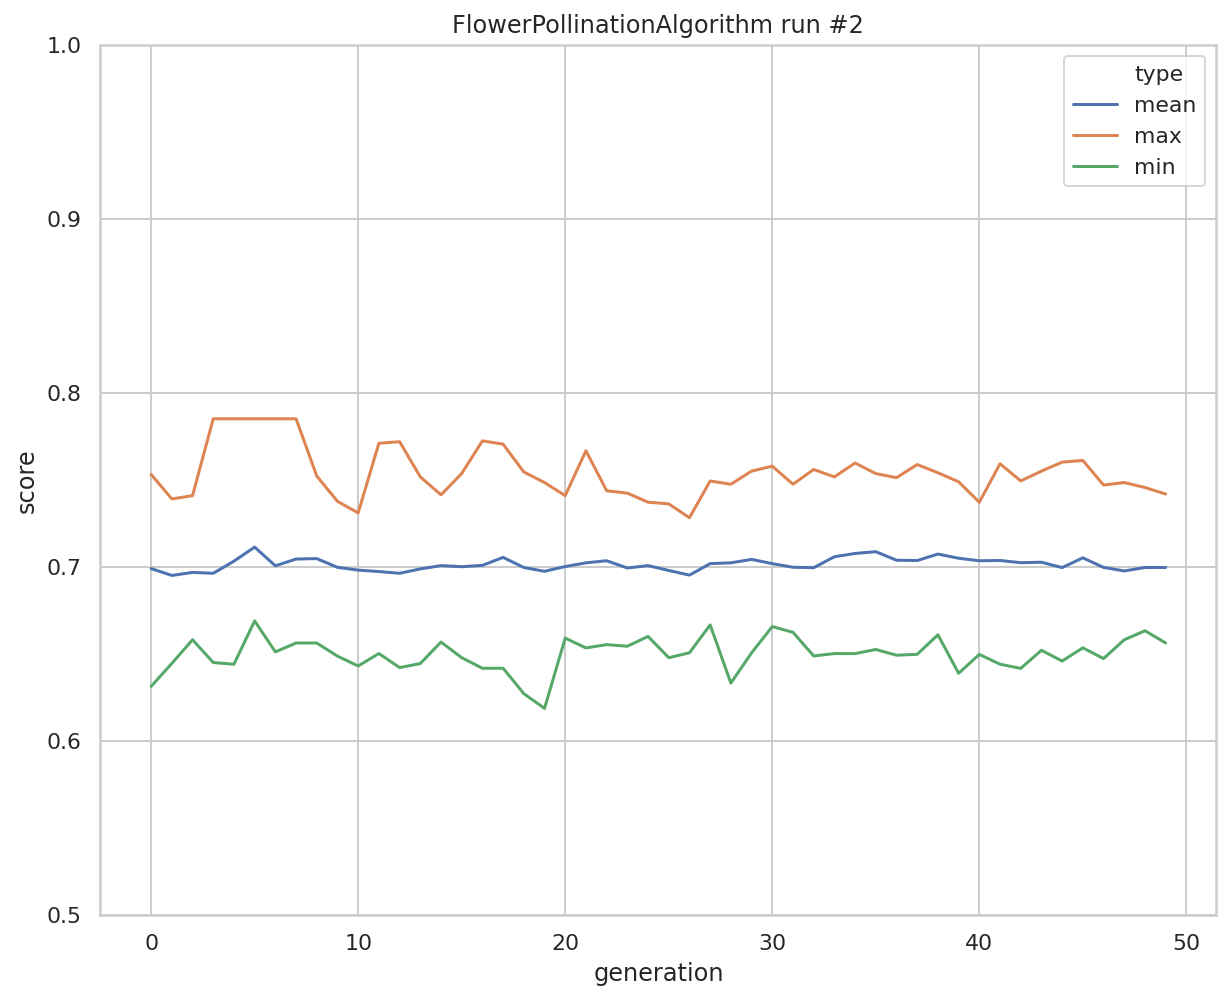

Score: 0.7850319655069877
Number of features selected: 124




Mean score of 3 runs: 0.7750086728119734



Best score of 3 runs: 0.7850319655069877
Number of features selected: 124



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The best score is 0.7750086728119734 with population_size=50

CPU times: user 7min 30s, sys: 2.36 s, total: 7min 33s
Wall time: 7min 33s


In [17]:
%%time

from NiaPy.algorithms.basic import FlowerPollinationAlgorithm

run_experiment(FlowerPollinationAlgorithm())

### Grey Wolf Algorithm

[Grey Wolf Algorithm](https://github.com/NiaOrg/NiaPy/blob/master/NiaPy/algorithms/basic/gwo.py) default parameters: _there are no parameters other then population size_

GreyWolfOptimizer
population_size=10
number_of_generations=50
--------------
Run 1
--------------


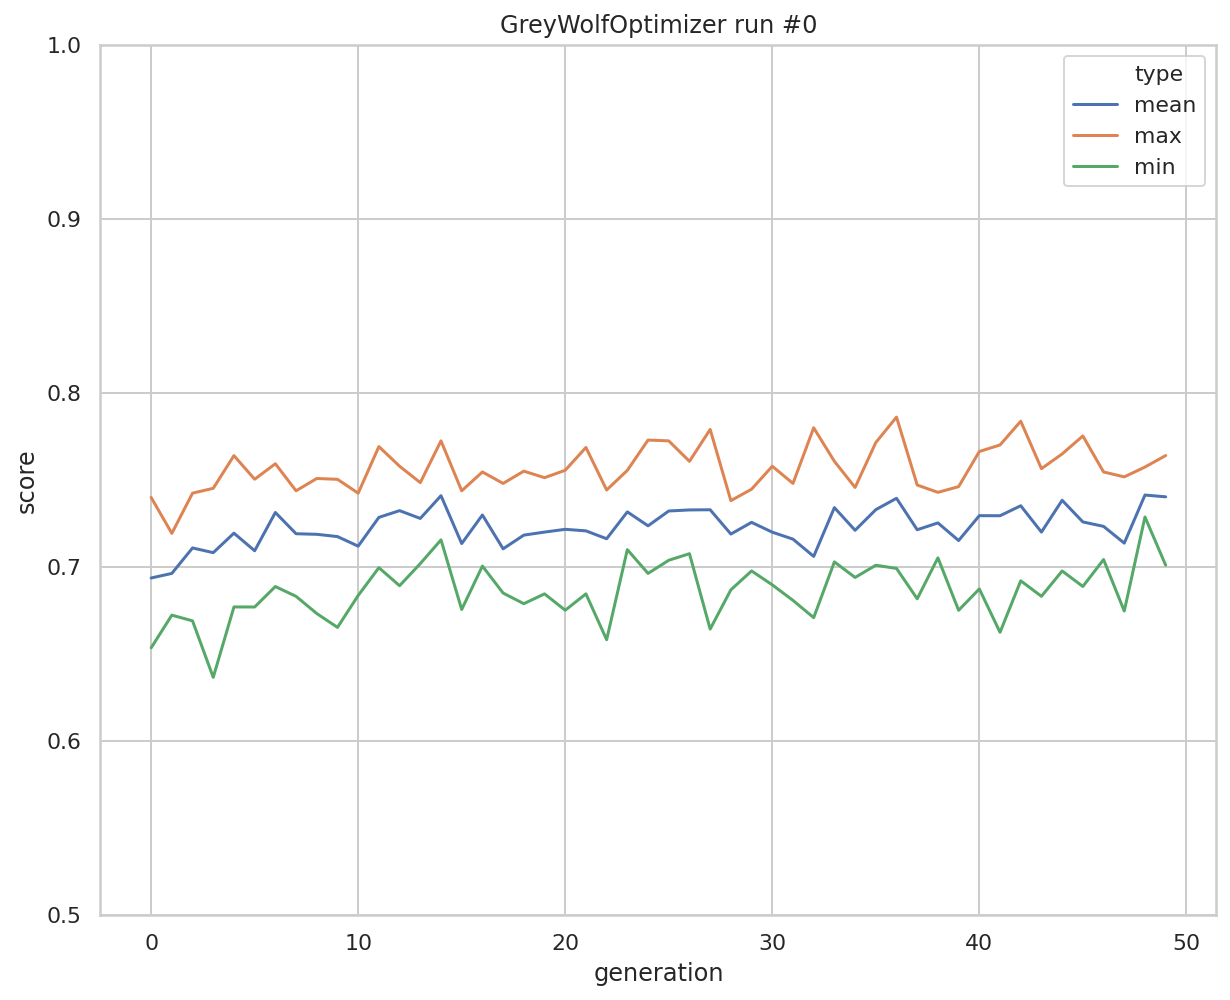

Score: 0.7859983645554565
Number of features selected: 67



--------------
Run 2
--------------


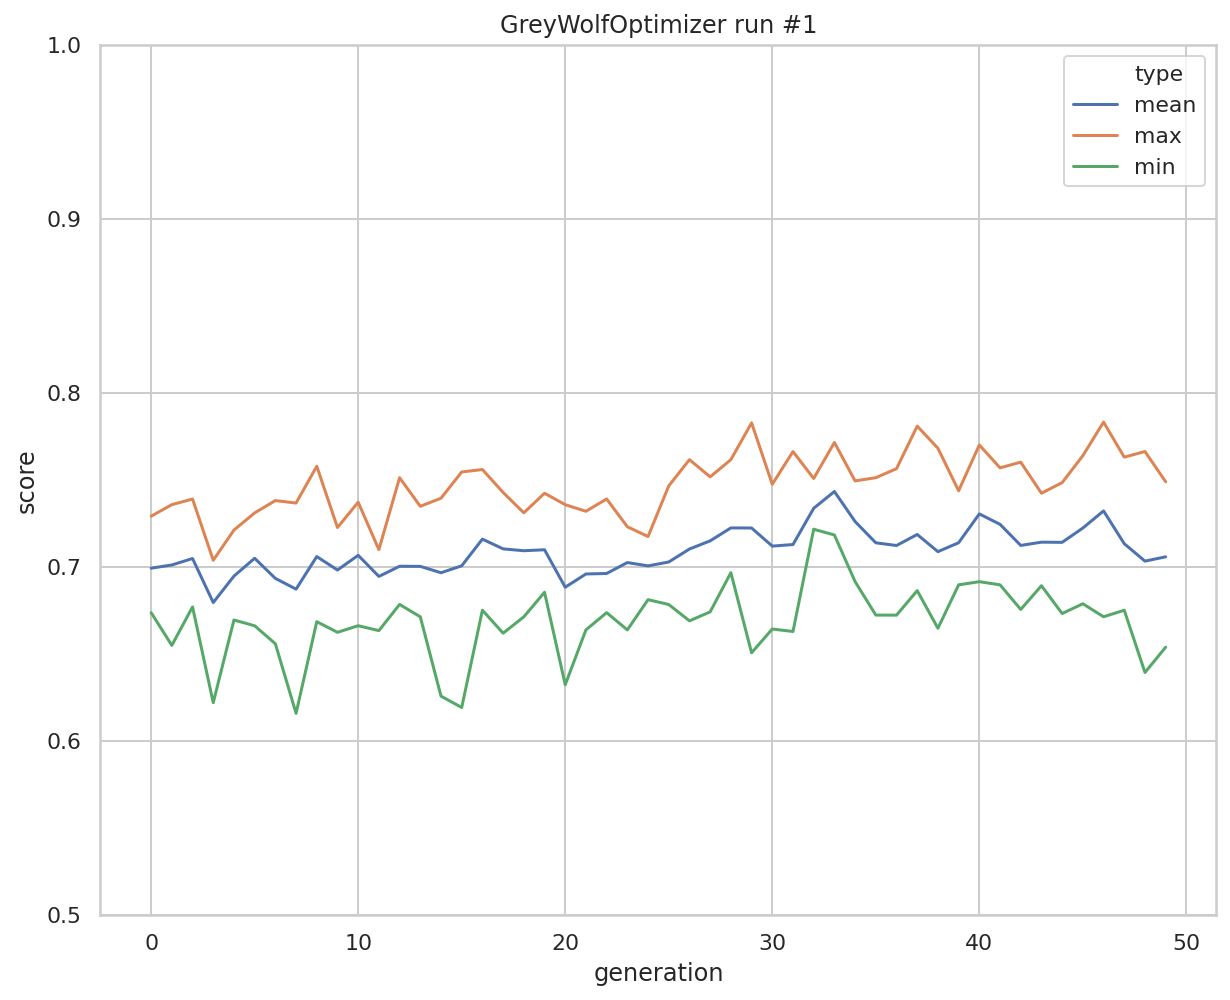

Score: 0.7831363366042224
Number of features selected: 84



--------------
Run 3
--------------


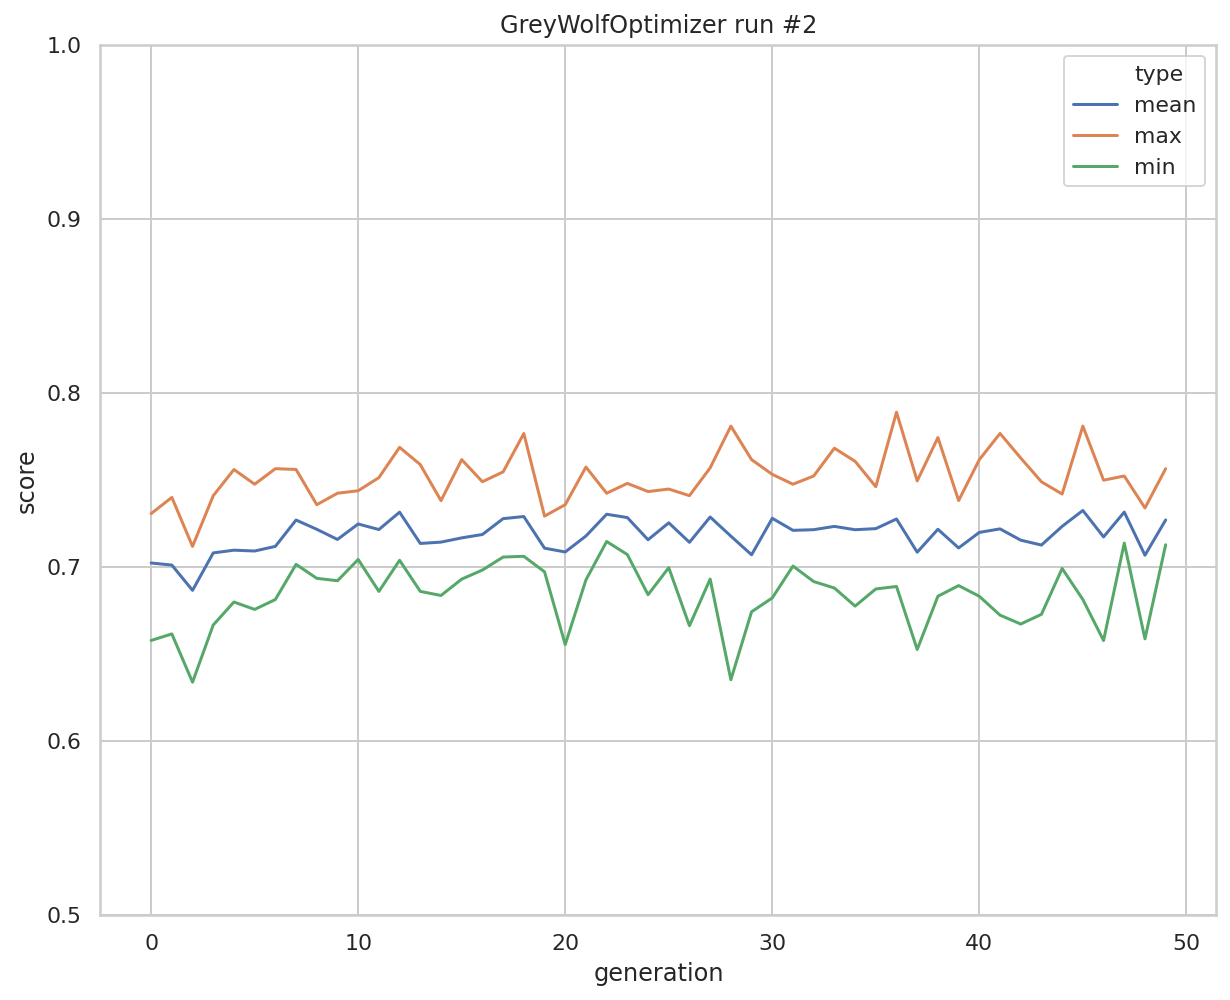

Score: 0.7888232233125186
Number of features selected: 80




Mean score of 3 runs: 0.7859859748240657



Best score of 3 runs: 0.7888232233125186
Number of features selected: 80



GreyWolfOptimizer
population_size=25
number_of_generations=50
--------------
Run 1
--------------


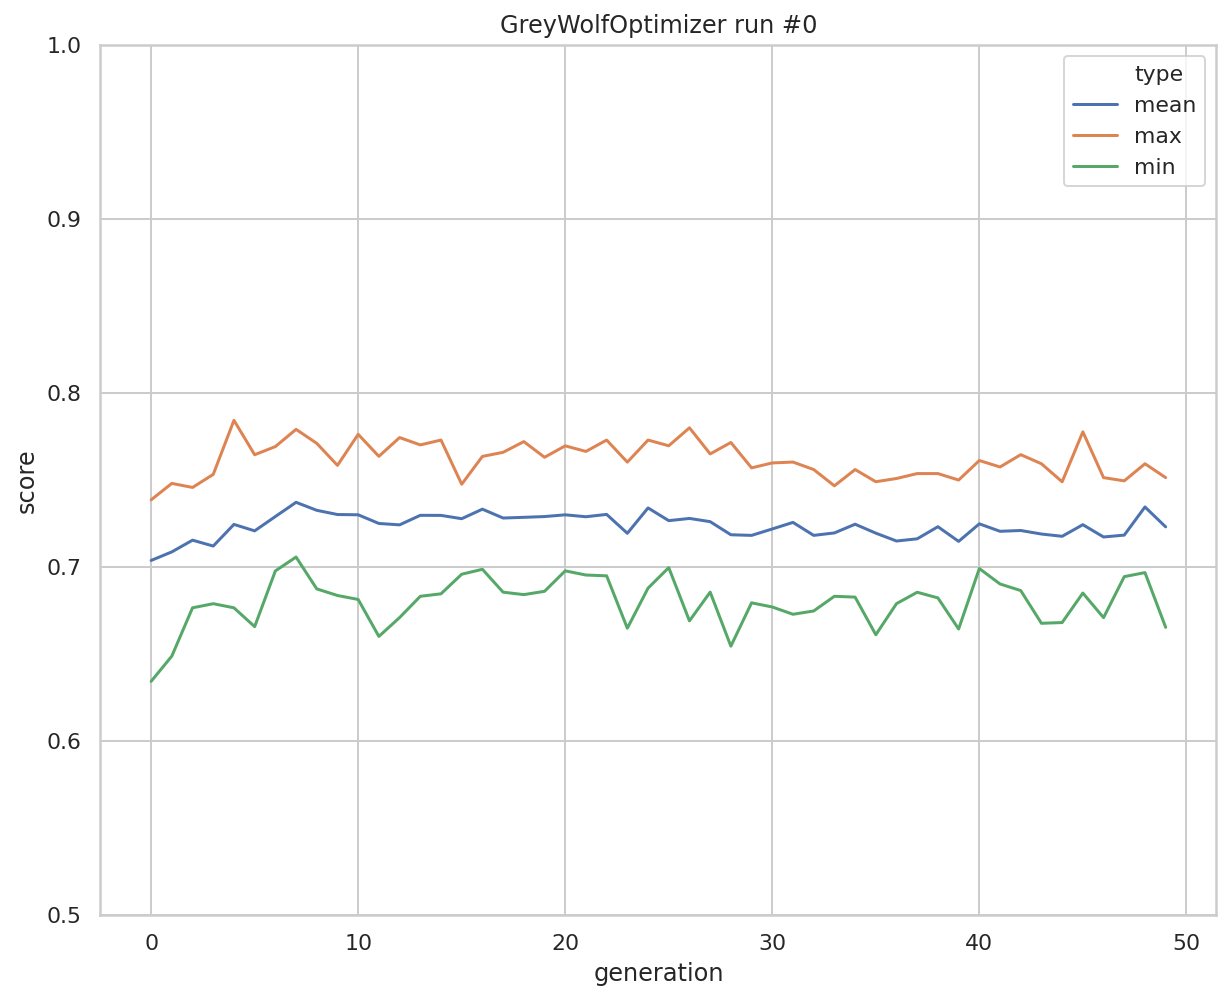

Score: 0.7841399048468629
Number of features selected: 97



--------------
Run 2
--------------


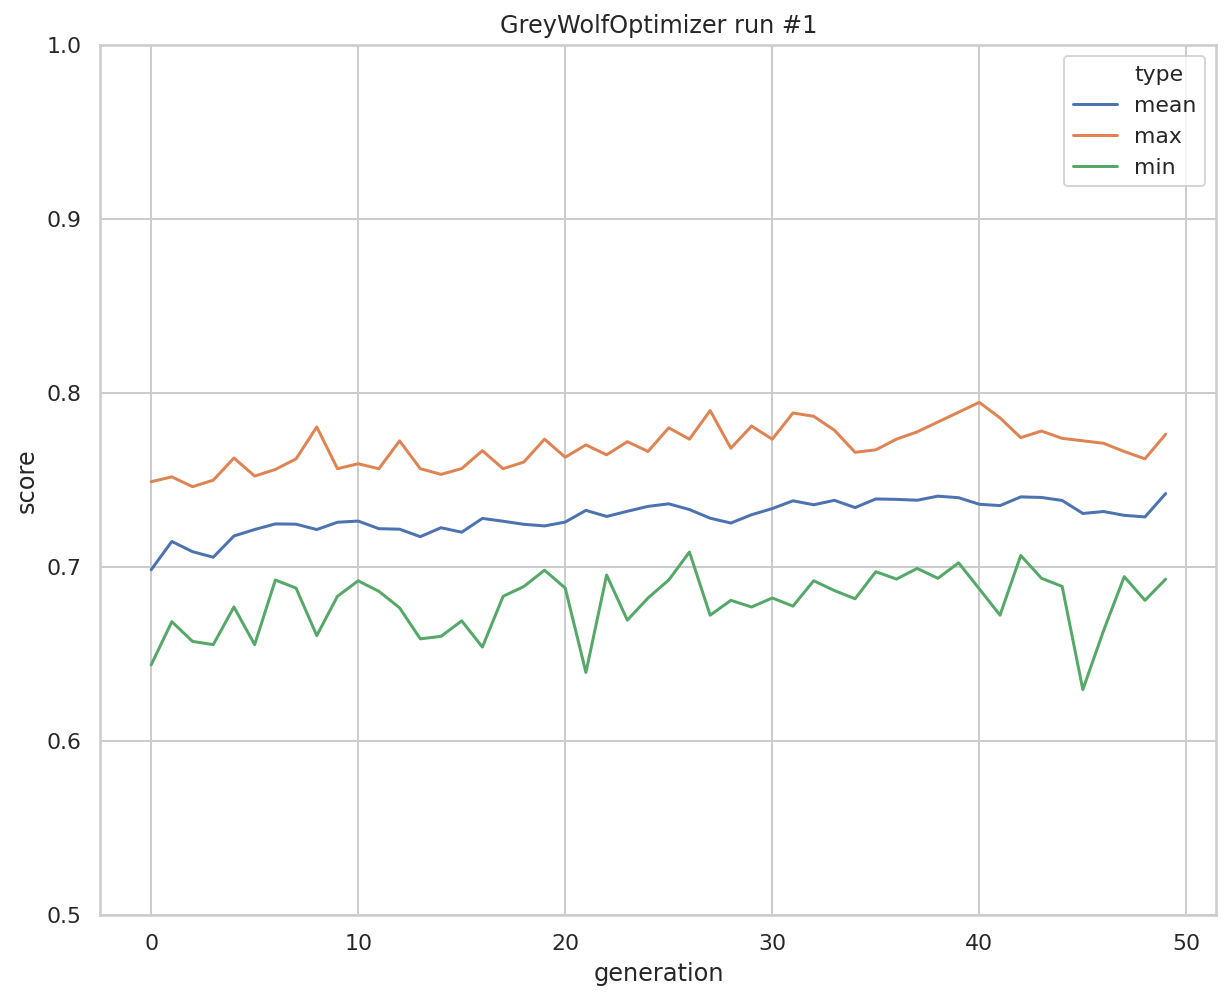

Score: 0.7944729408266429
Number of features selected: 69



--------------
Run 3
--------------


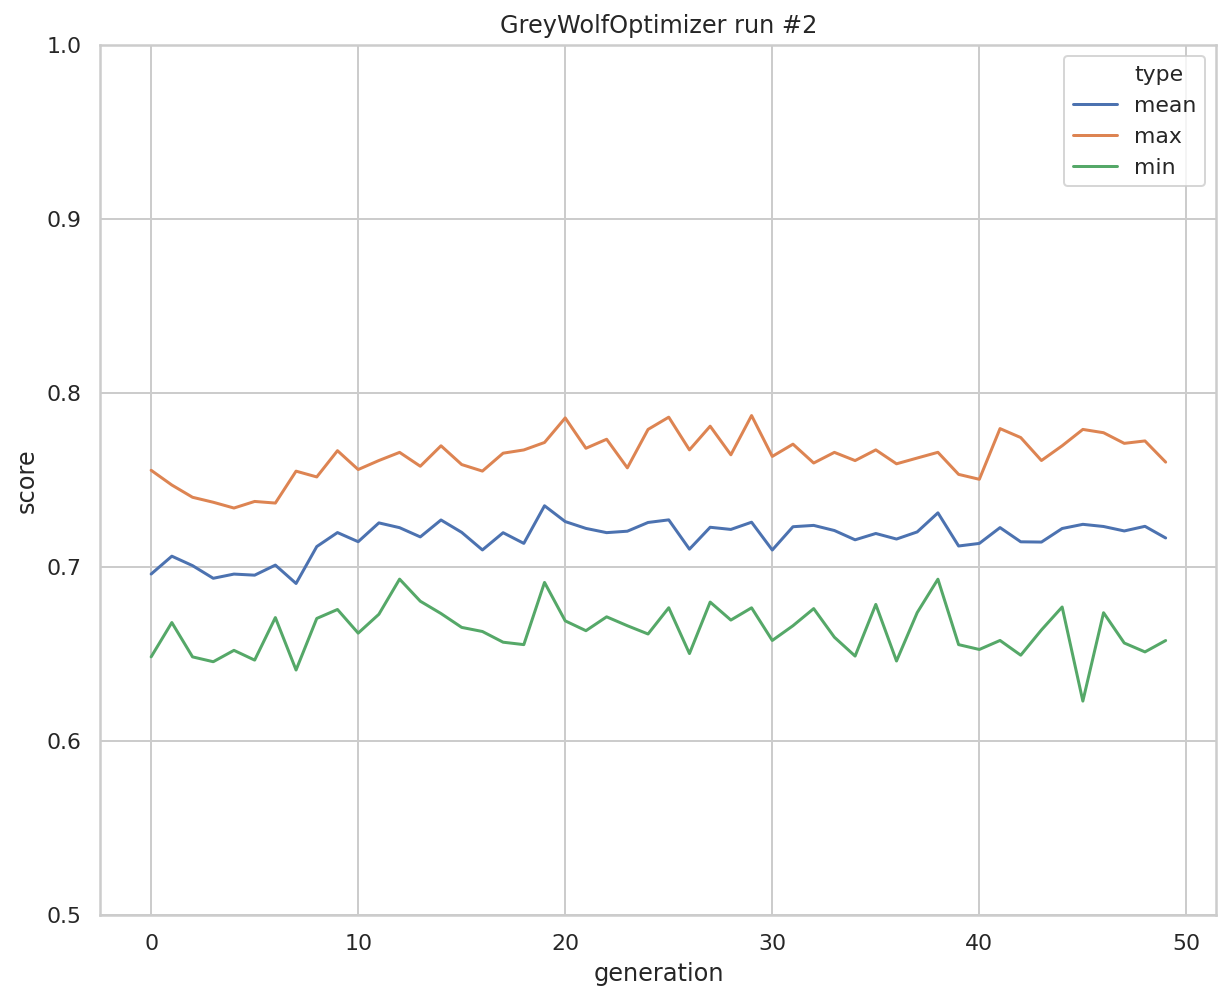

Score: 0.7868904252155812
Number of features selected: 64




Mean score of 3 runs: 0.7885010902963624



Best score of 3 runs: 0.7944729408266429
Number of features selected: 69



GreyWolfOptimizer
population_size=50
number_of_generations=50
--------------
Run 1
--------------


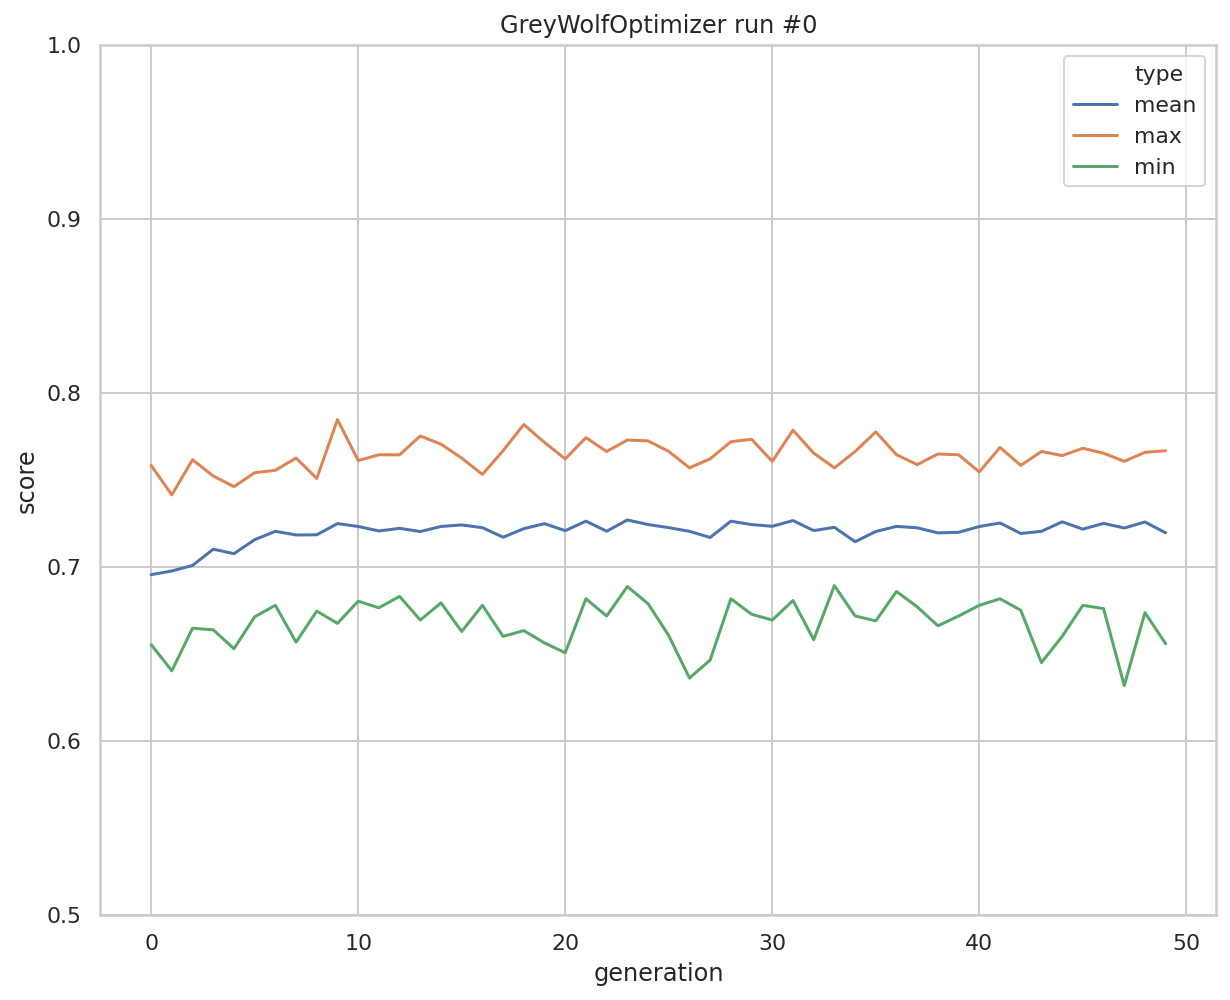

Score: 0.7845673505798395
Number of features selected: 96



--------------
Run 2
--------------


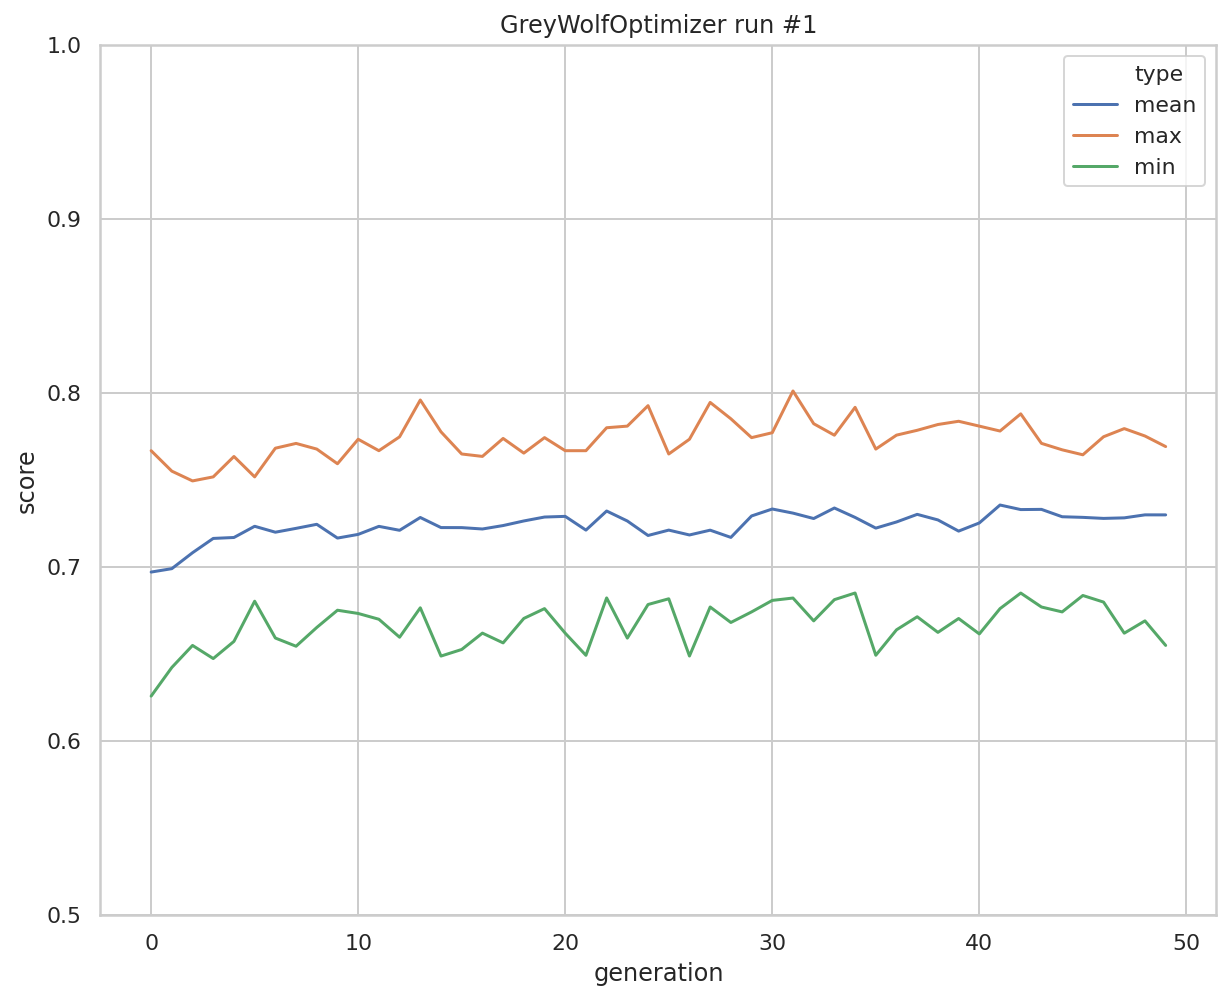

Score: 0.801014719000892
Number of features selected: 74



--------------
Run 3
--------------


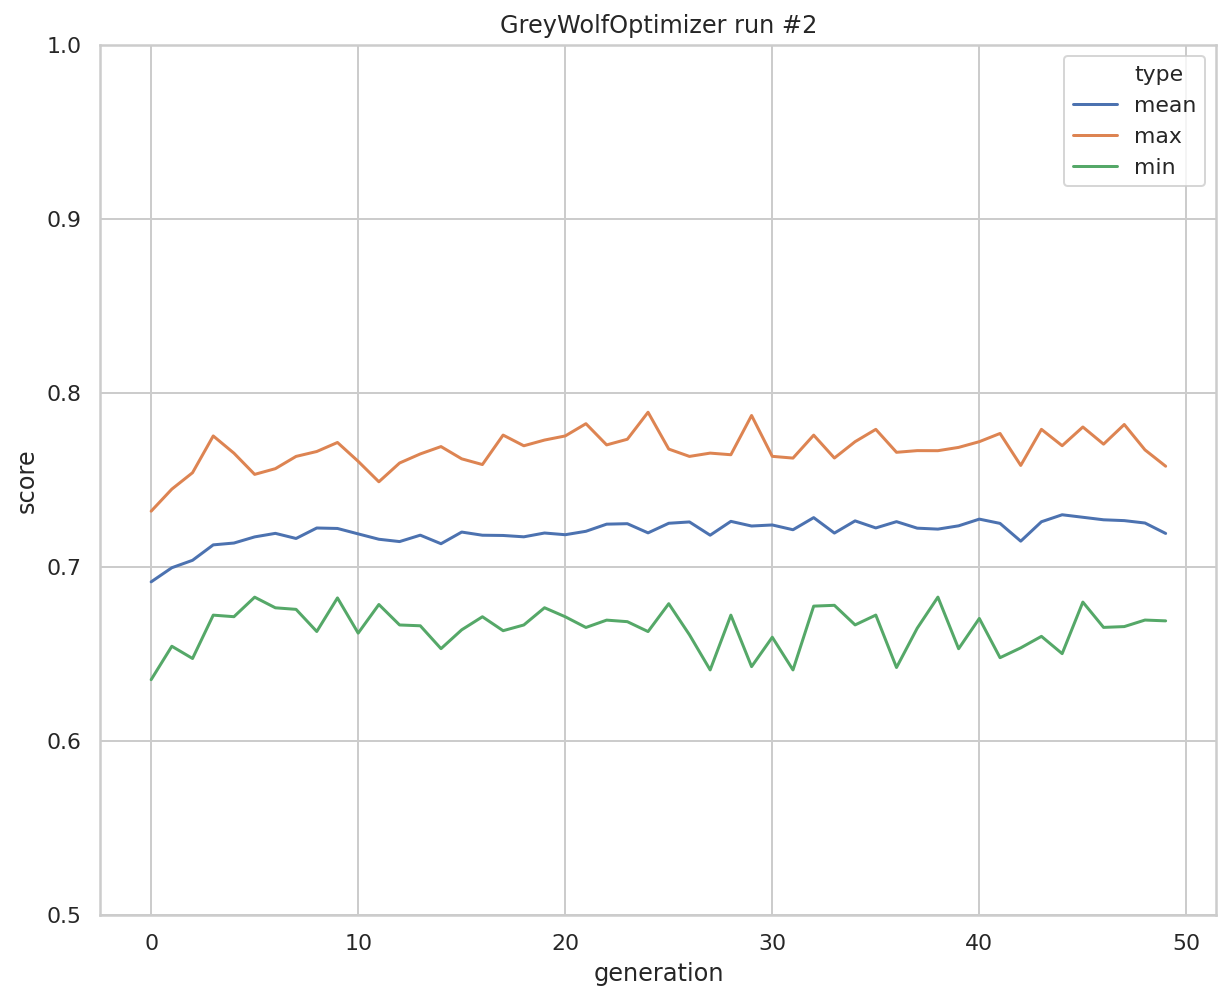

Score: 0.7887860541183467
Number of features selected: 83




Mean score of 3 runs: 0.791456041233026



Best score of 3 runs: 0.801014719000892
Number of features selected: 74



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The best score is 0.791456041233026 with population_size=50

CPU times: user 5min 26s, sys: 1.11 s, total: 5min 27s
Wall time: 5min 27s


In [20]:
%%time

from NiaPy.algorithms.basic import GreyWolfOptimizer

run_experiment(GreyWolfOptimizer())